https://towardsdatascience.com/pymc-marketing-the-key-to-advanced-clv-customer-lifetime-value-forecasting-bc0730973c0a

# Git

In [1]:
!git clone https://github.com/Mykrass/Effective-CLV-Modeling

Cloning into 'Effective-CLV-Modeling'...
remote: Enumerating objects: 127, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 127 (delta 23), reused 6 (delta 6), pack-reused 85
Receiving objects: 100% (127/127), 9.09 MiB | 14.06 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [2]:
!ls -GFlash --color ./Effective-CLV-Modeling

total 68K
4.0K drwxr-xr-x 3 root 4.0K Nov 20 19:09  ./
4.0K drwxr-xr-x 1 root 4.0K Nov 20 19:08  ../
 48K -rw-r--r-- 1 root  47K Nov 20 19:09  arcade_ltv.csv
4.0K -rw-r--r-- 1 root 1.1K Nov 20 19:09 'devtodev Arkade - SQL query for extracting data'
4.0K drwxr-xr-x 8 root 4.0K Nov 20 19:09  .git/
4.0K -rw-r--r-- 1 root  909 Nov 20 19:09  README.md


In [3]:
!cat ./Effective-CLV-Modeling/'devtodev Arkade - SQL query for extracting data'

/*
/*
SQL Report for Arkade - Extracting data
*/

declare 
@Interval interval = '3 month',
@country text[] = array['US', 'DE', 'RU'];


with t1 as(
  select
    to_char(eventtime, 'YYYY-MM-DD HH24:MI:SS') as dt
    ,devtodevid
    ,country
    ,product
    ,priceusd
    ,paymentid
    ,paymentcount
    ,paymentsum
  from p105094.payments p
  where eventtime >=current_date - @Interval and eventtime < current_date
  --and country = any (@country)
  and tester is false
  order by 1 asc
)

,t2 as(
 select 
    to_char(eventtime, 'YYYY-MM-DD HH24:MI:SS') as dt
    ,devtodevid
    ,item
    ,itemtype
    ,sessionid
  from p105094.purchases
  where created > current_date - @Interval and created < current_date
  --and country = any (@country)
  order by 1
)

,t3 as(
  select 
    t1.dt as "InvoiceDate"
    ,t1.devtodevid as "CustomerID"
    ,t1.paymentid as "InvoiceNo"
    ,t1.product as "StockCode"
    ,t2.item as "Description"
    ,t1.country as "Country"
    ,t1.priceusd as "UnitPrice"
    

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/drive/16XcUiRgTFF9eGs0Tc6iJ3mpFS7ue075y#scrollTo=ju8-3V0zxAPu"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/Mykrass/Effective-CLV-Modeling"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

# Customer Lifetime Value Prediction Demo

This script demonstrates the process of predicting Customer Lifetime Value (CLV) using the PyMC Marketing library.

The example is based on the [PyMC Marketing Quickstart](https://www.pymc-marketing.io/en/stable/notebooks/clv/clv_quickstart.html) and utilizes [the Online Retail dataset from the UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/352/online+retail).

## Installing and Importing Necessary Libraries

In [4]:
# Installing the PyMC Marketing library
!pip install pymc_marketing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.7/471.7 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 36.5 MB/s eta 0:00:00
  Attempting uninstall: pytensor
    Found existing installation: pytensor 2.14.2
    Uninstalling pytensor-2.14.2:
      Successfully uninstalled pytensor-2.14.2
  Attempting uninstall: pymc
    Found existing installation: pymc 5.7.2
    Uninstalling pymc-5.7.2:
      Successfully uninstalled pymc-5.7.2


In [5]:
!pip install openpyxl

In [6]:
# Importing required libraries
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
from arviz.labels import MapLabeller

from IPython.display import Image
from pymc_marketing import clv

In [7]:
# Setting the style of the plots
az.style.use("arviz-darkgrid")

%config InlineBackend.figure_format = "retina" # nice looking plots

## Data Loading and Preprocessing

In [12]:
!ls -GFlash --color ./Effective-CLV-Modeling

total 68K
4.0K drwxr-xr-x 3 root 4.0K Nov 20 19:09  ./
4.0K drwxr-xr-x 1 root 4.0K Nov 20 19:08  ../
 48K -rw-r--r-- 1 root  47K Nov 20 19:09  arcade_ltv.csv
4.0K -rw-r--r-- 1 root 1.1K Nov 20 19:09 'devtodev Arkade - SQL query for extracting data'
4.0K drwxr-xr-x 8 root 4.0K Nov 20 19:09  .git/
4.0K -rw-r--r-- 1 root  909 Nov 20 19:09  README.md


In [13]:
!head ./Effective-CLV-Modeling/arcade_ltv.csv

InvoiceDate;CustomerID;InvoiceNo;StockCode;Description;Country;UnitPrice;Quantity
2023-08-21 05:08:48;18312564;GPA.1555-2142-9271-90373;special offer;dynamite 2;BR;8;2
2023-08-21 08:26:15;18331000;GPA.7960-5768-9715-21679;special offer;dynamite 2;US;8;1
2023-08-21 11:29:22;18333952;GPA.3689-1188-2521-37427;special offer;dynamite 5;IT;8;1
2023-08-21 11:39:24;18335703;GPA.7457-5106-1437-58803;new offer;dynamite 2;ID;1;1
2023-08-21 15:12:14;18330285;GPA.2211-2686-5667-70990;starterpack;dynamite 2;IT;2.5;1
2023-08-21 19:17:09;18325581;GPA.9048-2457-4073-52985;offer_1;dynamite 2;US;50;4
2023-08-21 19:52:33;18336690;GPA.7528-2937-9590-92642;popular offer;dynamite 2;GB;12;2
2023-08-21 22:04:31;18329562;GPA.4009-4546-8789-69890;special offer;dynamite 2;SA;8;1
2023-08-21 23:18:08;18315847;GPA.9074-6024-2420-66174;offer4;dynamite 2;GB;50;2


In [14]:
data_raw = pd.read_csv('./Effective-CLV-Modeling/arcade_ltv.csv', sep=';')
data_raw['CustomerID'] = data_raw['CustomerID'].astype(str)
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 565 entries, 0 to 564
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceDate  565 non-null    object 
 1   CustomerID   565 non-null    object 
 2   InvoiceNo    565 non-null    object 
 3   StockCode    565 non-null    object 
 4   Description  565 non-null    object 
 5   Country      565 non-null    object 
 6   UnitPrice    565 non-null    float64
 7   Quantity     565 non-null    int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 35.4+ KB


In [17]:
# Handling Return Orders
# Extracting rows where InvoiceNo starts with "C"
cancelled_orders = data_raw[data_raw['InvoiceNo'].astype(str).str.startswith("C")]

# Create a temporary DataFrame with the columns we want to match on, and also negate the 'Quantity' column
cancelled_orders['Quantity'] = -cancelled_orders['Quantity']

# Merge the original DataFrame with the temporary DataFrame on the columns we want to match
merged_data = pd.merge(data_raw, cancelled_orders[['CustomerID', 'StockCode', 'Quantity', 'UnitPrice']],
                       on=['CustomerID', 'StockCode', 'Quantity', 'UnitPrice'],
                       how='left', indicator=True)

# Filter out rows where the merge found a match, and also filter out the original return orders
data_raw = merged_data[(merged_data['_merge'] == 'left_only') & (~merged_data['InvoiceNo'].astype(str).str.startswith("C"))]

# Drop the indicator column
data_raw = data_raw.drop(columns=['_merge'])
data_raw

,InvoiceDate,CustomerID,InvoiceNo,StockCode,Description,Country,UnitPrice,Quantity
0,2023-08-21 05:08:48,18312564,GPA.1555-2142-9271-90373,special offer,dynamite 2,BR,8.0,2
1,2023-08-21 08:26:15,18331000,GPA.7960-5768-9715-21679,special offer,dynamite 2,US,8.0,1
2,2023-08-21 11:29:22,18333952,GPA.3689-1188-2521-37427,special offer,dynamite 5,IT,8.0,1
3,2023-08-21 11:39:24,18335703,GPA.7457-5106-1437-58803,new offer,dynamite 2,ID,1.0,1
4,2023-08-21 15:12:14,18330285,GPA.2211-2686-5667-70990,starterpack,dynamite 2,IT,2.5,1
...,...,...,...,...,...,...,...,...
560,2023-11-19 01:40:52,19371023,GPA.1341-4675-3596-30898,special offer,dynamite 2,US,8.0,9
561,2023-11-19 04:32:54,19581002,GPA.8732-5232-5726-80792,new offer,dynamite 2,RU,1.0,1
562,2023-11-19 16:12:28,19588027,GPA.2476-9348-9491-80379,offer4,dynamite 5,TR,50.0,1
563,2023-11-19 17:48:26,19559555,GPA.4162-2621-4331-80005,special offer,dynamite 2,US,8.0,1


In [18]:
# Selecting relevant features and calculating total sales
features = ['CustomerID', 'InvoiceNo', 'InvoiceDate', 'Quantity', 'UnitPrice', 'Country']
data = data_raw[features]
data['TotalSales'] = data['Quantity'].multiply(data['UnitPrice'])

# Removing transactions with missing customer IDs as they don't contribute to individual customer behavior
data = data[data['CustomerID'].notna()]
data['CustomerID'] = data['CustomerID'].astype(int).astype(str)
print(data.shape)
data

(565, 7)


<ipython-input-18-39405f3bccf1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['TotalSales'] = data['Quantity'].multiply(data['UnitPrice'])


,CustomerID,InvoiceNo,InvoiceDate,Quantity,UnitPrice,Country,TotalSales
0,18312564,GPA.1555-2142-9271-90373,2023-08-21 05:08:48,2,8.0,BR,16.0
1,18331000,GPA.7960-5768-9715-21679,2023-08-21 08:26:15,1,8.0,US,8.0
2,18333952,GPA.3689-1188-2521-37427,2023-08-21 11:29:22,1,8.0,IT,8.0
3,18335703,GPA.7457-5106-1437-58803,2023-08-21 11:39:24,1,1.0,ID,1.0
4,18330285,GPA.2211-2686-5667-70990,2023-08-21 15:12:14,1,2.5,IT,2.5
...,...,...,...,...,...,...,...
560,19371023,GPA.1341-4675-3596-30898,2023-11-19 01:40:52,9,8.0,US,72.0
561,19581002,GPA.8732-5232-5726-80792,2023-11-19 04:32:54,1,1.0,RU,1.0
562,19588027,GPA.2476-9348-9491-80379,2023-11-19 16:12:28,1,50.0,TR,50.0
563,19559555,GPA.4162-2621-4331-80005,2023-11-19 17:48:26,1,8.0,US,8.0


In [19]:
# Checking for missing values
pd.DataFrame(zip(data.isnull().sum(), data.isnull().sum()/len(data)), columns=['Count', 'Proportion'], index=data.columns)

,Count,Proportion
CustomerID,0,0.0
InvoiceNo,0,0.0
InvoiceDate,0,0.0
Quantity,0,0.0
UnitPrice,0,0.0
Country,0,0.0
TotalSales,0,0.0


## Exploratory Data Analysis

In [20]:
data['InvoiceDate'].min()

'2023-08-21 05:08:48'

In [21]:
data['InvoiceDate'].max()

'2023-11-19 19:55:28'

In [22]:
# Summarizing the dataset's content to understand its scope
#maxdate = data['InvoiceDate'].dt.date.max()
#mindate = data['InvoiceDate'].dt.date.min()
maxdate = data['InvoiceDate'].max()
mindate = data['InvoiceDate'].min()
unique_cust = data['CustomerID'].nunique()
tot_quantity = data['Quantity'].sum()
tot_sales = data['TotalSales'].sum()

print(f"The Time range of transactions is: {mindate} to {maxdate}")
print(f"Total number of unique customers: {unique_cust}")
print(f"Total Quantity Sold: {tot_quantity}")
print(f"Total Sales for the period: {tot_sales}")

The Time range of transactions is: 2023-08-21 05:08:48 to 2023-11-19 19:55:28
Total number of unique customers: 545
Total Quantity Sold: 1827
Total Sales for the period: 41217.0


## BG/NBD Model

The BG/NBD model is a probabilistic model that predicts the purchases customers will make in a given period based on their past behavior.

## RFM-T Format
We will use the BG/NBD model to infer the frequency of repeat purchases for all customers in the dataset.

* `frequency` represents the number of _repeat_ purchases that a customer has made, i.e. one less than the total number of purchases;
* `T` represents a customer's "age", i.e. the duration between a customer's first purchase and the end of the period of study. In this example notebook, the units of time are in weeks;
* `recency` represents the timepoint when a customer made their most recent purchase. This is also equal to the duration between a customer’s first non-repeat purchase (usually time 0) and last purchase. If a customer has made only 1 purchase, their recency is 0;
* `monetary_value` represents the average value of a given customer’s purchases. This is equal to the sum of all a customer’s purchases divided by the total number of purchases.

In [23]:
# Here, we prepare a summary from transaction data, transforming individual transaction data into data at the customer level.

data_summary_rfm = clv.utils.clv_summary(data, 'CustomerID', 'InvoiceDate', 'TotalSales')
data_summary_rfm = data_summary_rfm.rename(columns={'CustomerID': 'customer_id'})
data_summary_rfm.index = data_summary_rfm['customer_id']
data_summary_rfm.head()

,customer_id,frequency,recency,T,monetary_value
customer_id,,,,,
18312564,18312564,0.0,0.0,90.0,0.0
18315847,18315847,0.0,0.0,90.0,0.0
18320056,18320056,0.0,0.0,81.0,0.0
18325581,18325581,0.0,0.0,90.0,0.0
18325951,18325951,0.0,0.0,90.0,0.0


In [24]:
data_summary_rfm = data_summary_rfm[data_summary_rfm['monetary_value'] > 0]
data_summary_rfm

,customer_id,frequency,recency,T,monetary_value
customer_id,,,,,
18484138,18484138,1.0,2.0,72.0,300.0


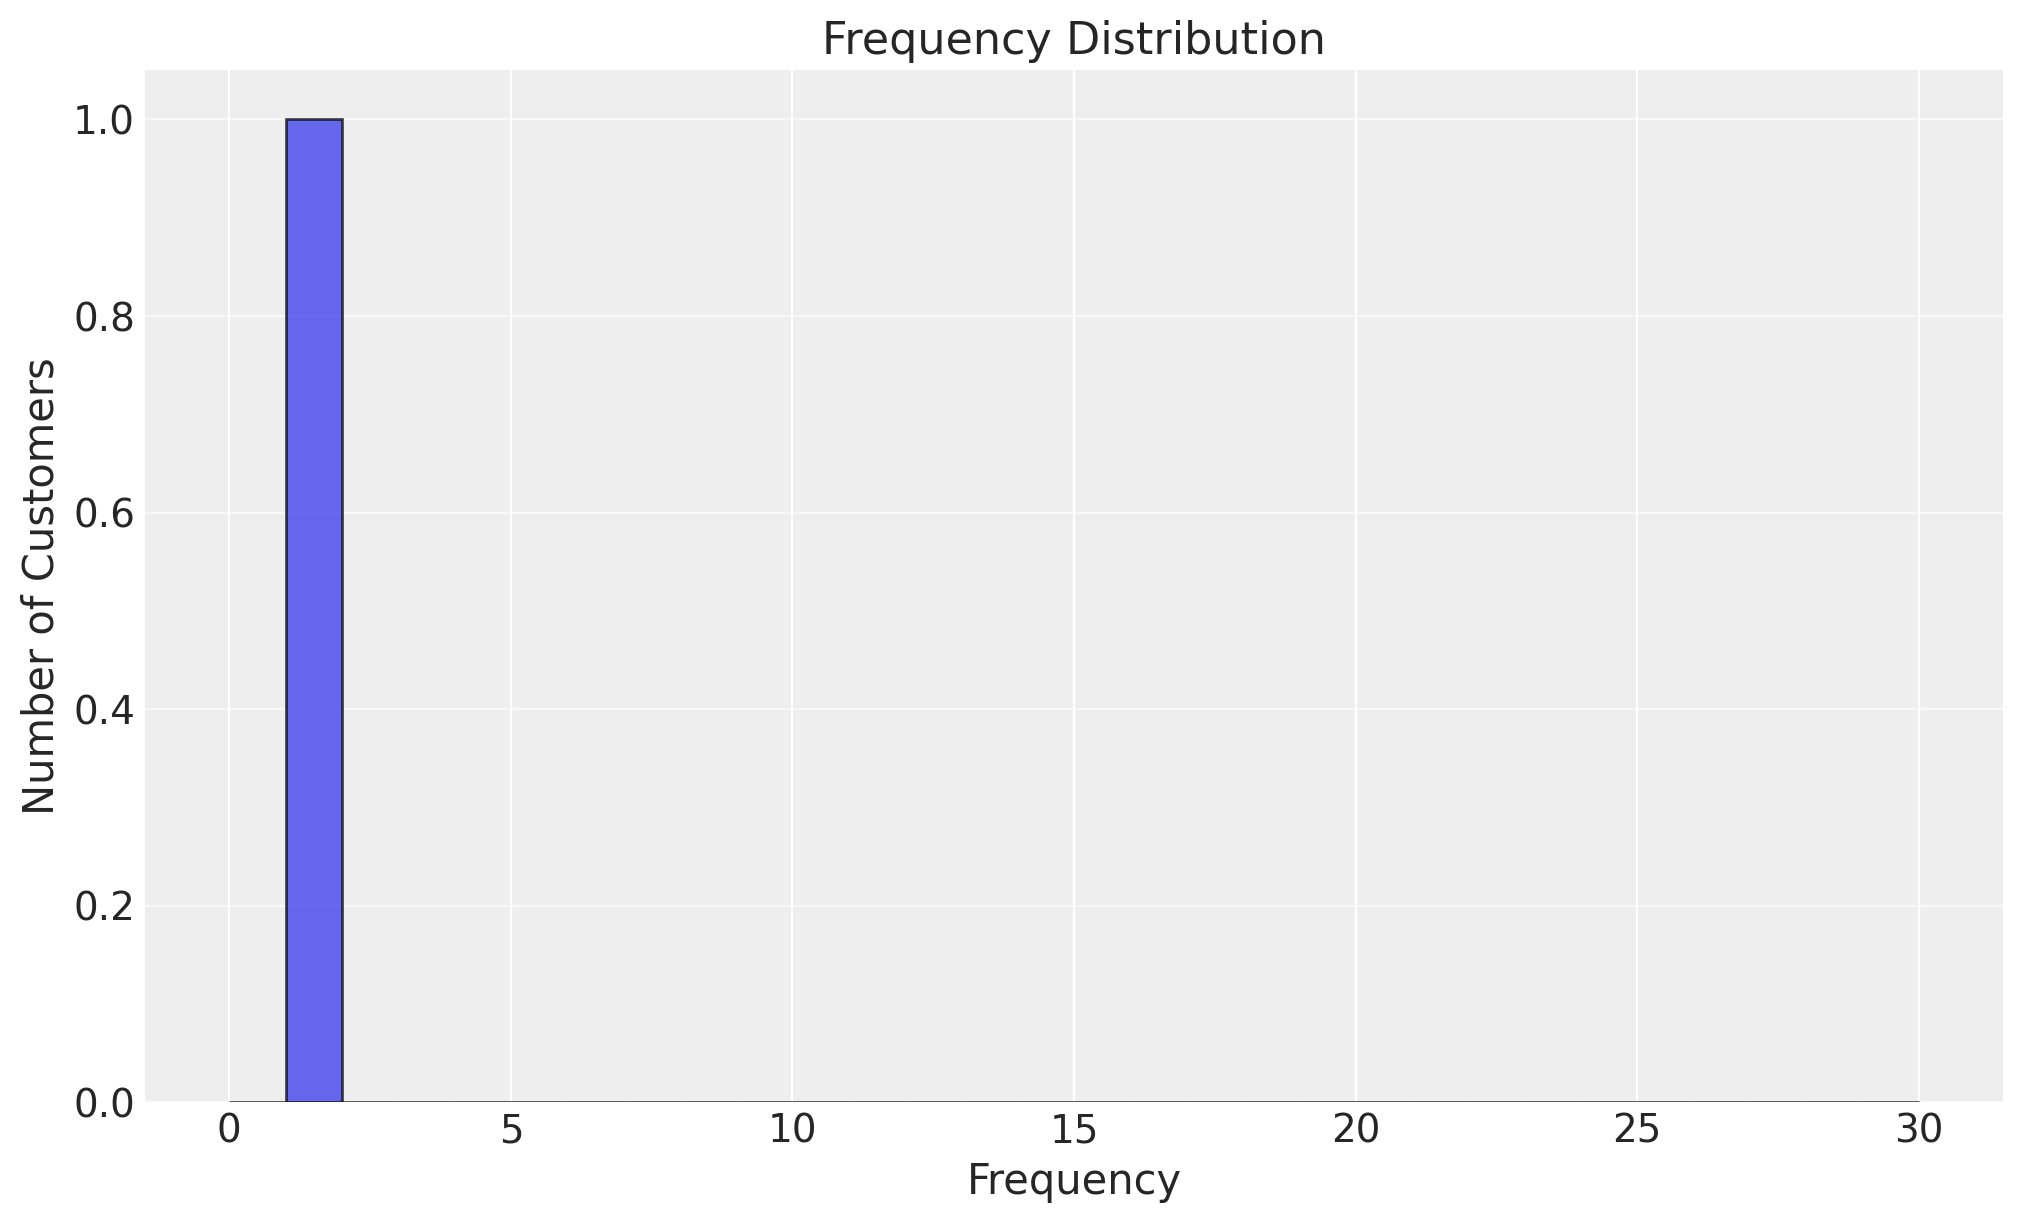

Percentage of customers who purchased only once: 100.0%


In [25]:
# Plotting the frequency distribution of customers
plt.figure(figsize=(10, 6))
plt.hist(data_summary_rfm['frequency'], bins=30, range=[0, 30], edgecolor='k', alpha=0.7)
plt.title('Frequency Distribution')
plt.xlabel('Frequency')
plt.ylabel('Number of Customers')
plt.grid(axis='y', alpha=0.6)
plt.show()

one_time = round(sum(data_summary_rfm['frequency'] == 1) / float(len(data_summary_rfm)) * 100, 2)
print(f"Percentage of customers who purchased only once: {one_time}%")


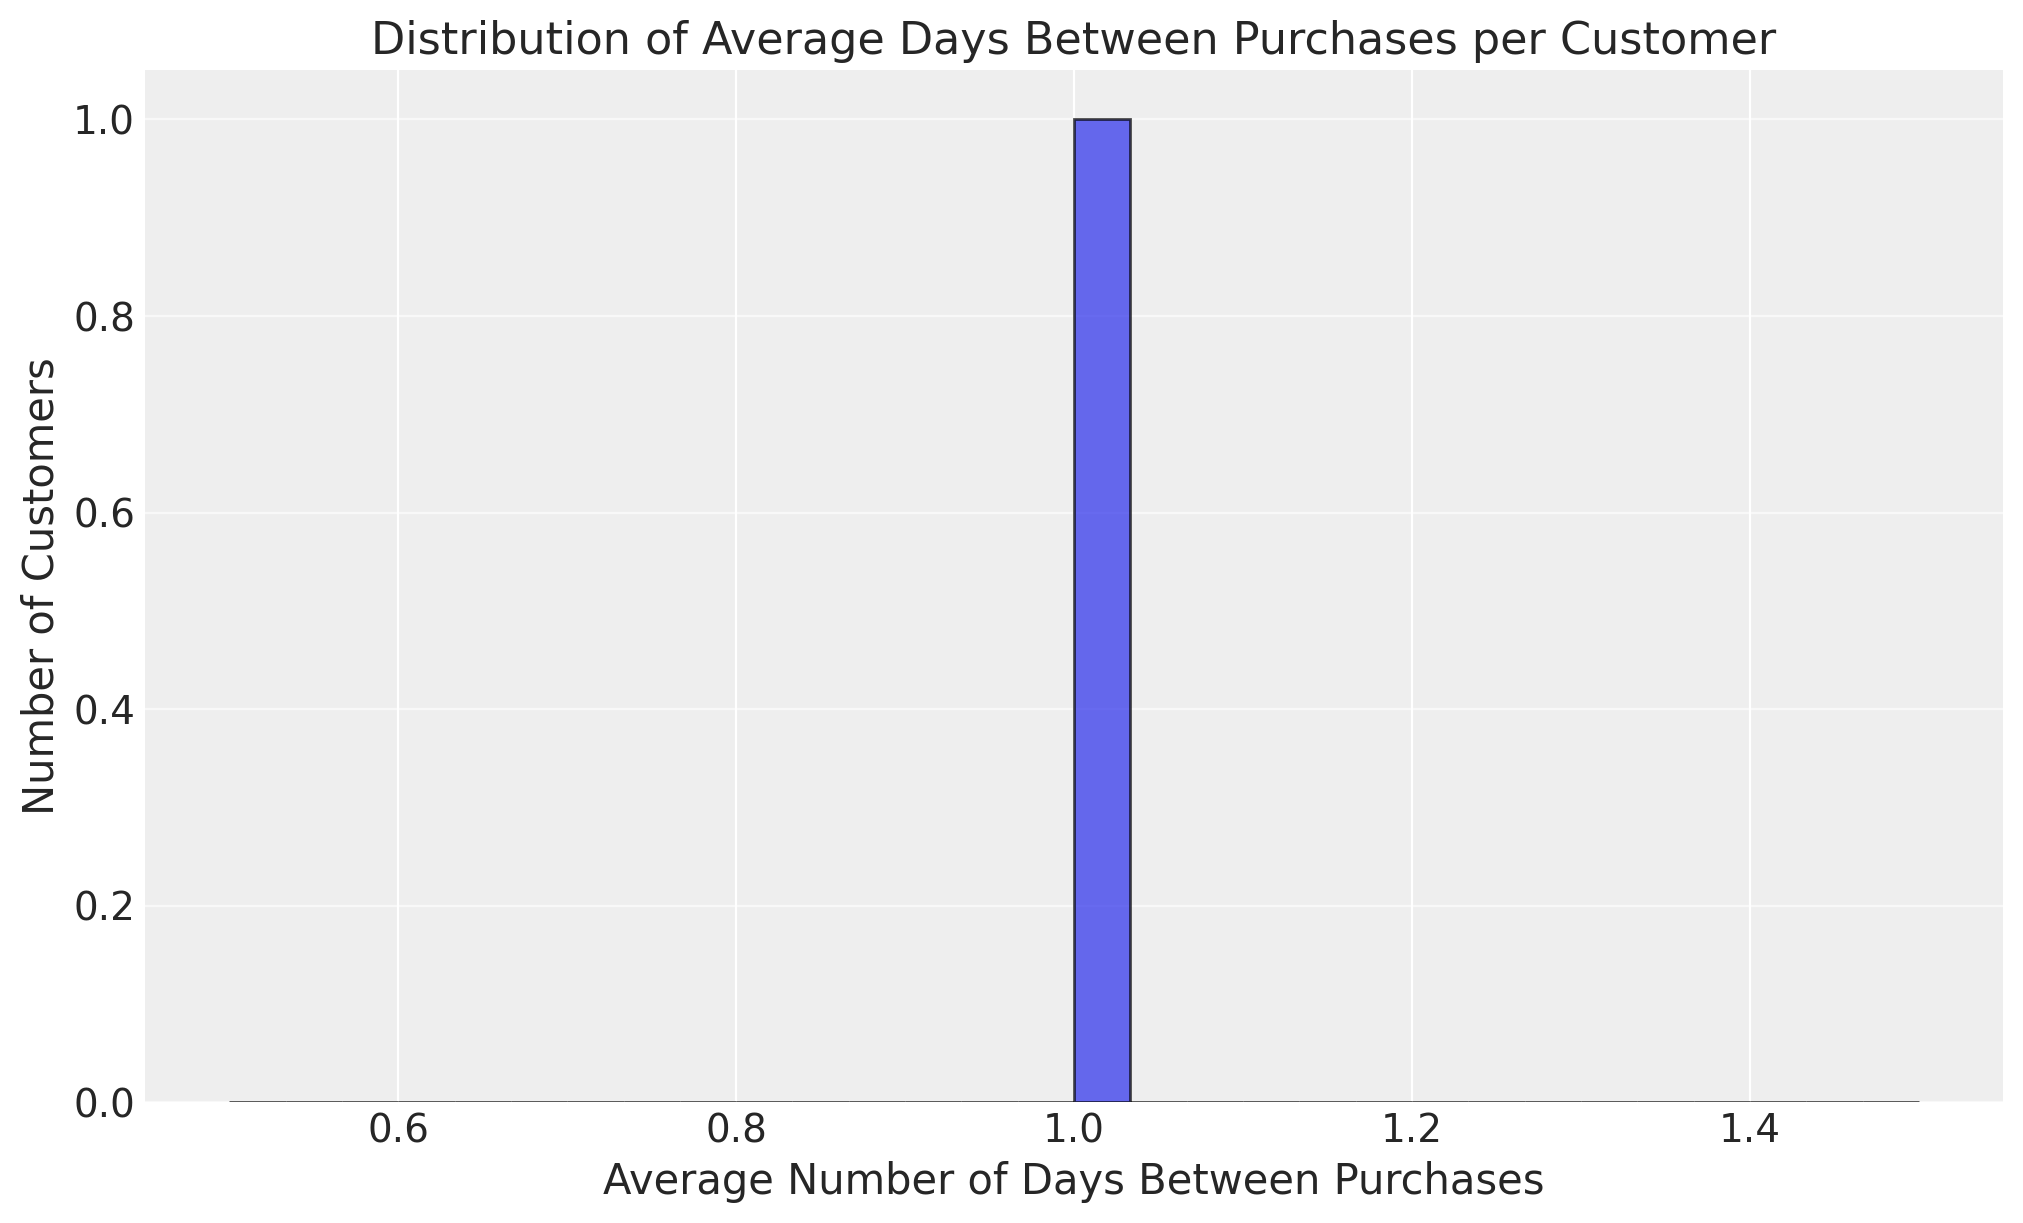

In [26]:
# Calculating Days Between Purchases

# Select distinct CustomerID and InvoiceDate
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
unique_purchases = data[['CustomerID', 'InvoiceDate']].drop_duplicates()

# Sorting values to ensure the calculation of the difference correctly
unique_purchases = unique_purchases.sort_values(['CustomerID', 'InvoiceDate'])

# Calculating the difference in days between current and next purchase
unique_purchases['NextInvoiceDate'] = unique_purchases.groupby('CustomerID')['InvoiceDate'].shift(-1)
unique_purchases['DaysBetween'] = (unique_purchases['NextInvoiceDate'] - unique_purchases['InvoiceDate']).dt.days

# Calculating Average Days
customer_avg_days = unique_purchases.groupby('CustomerID')['DaysBetween'].mean().dropna()

# Plotting the Histogram
plt.figure(figsize=(10, 6))
plt.hist(customer_avg_days, bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Average Days Between Purchases per Customer')
plt.xlabel('Average Number of Days Between Purchases')
plt.ylabel('Number of Customers')
plt.grid(axis='y', alpha=0.6)
plt.show()

In [27]:
data_summary_rfm

,customer_id,frequency,recency,T,monetary_value
customer_id,,,,,
18484138,18484138,1.0,2.0,72.0,300.0


In [28]:
# Initializing the BG/NBD model.
bgm = clv.BetaGeoModel(
    data = data_summary_rfm,
)
bgm.build_model()
bgm

BG/NBD
         a ~ HalfFlat()
         b ~ HalfFlat()
     alpha ~ HalfFlat()
         r ~ HalfFlat()
likelihood ~ Potential(f(r, alpha, b, a))

The default priors for the 4 parameters follow a HalfFlat distribution, which is an improper positive uniform distribution. For small datasets this prior can yield implausible posteriors. To avoid this problem, more informative priors can be specified by defining custom PyMC distributions.

Here, we will replace the HalfFlat default by more well-behaved HalfNormal priors with a standard deviation of 10.
Customization priors is possible by passing a dictionary with keys being the name of the prior, and values being a dictionary with 2 keys: 'dist' representing the name of PyMC distribution and 'kwargs' that holds an optional dictionary of all parameters we wish to pass to the distribution

In [29]:
# While the default priors work well for large datasets, they can be too broad or non-informative for smaller datasets.
# Therefore, we're refining our model by specifying more informative priors for the model's parameters.
# This step helps in guiding the model towards more realistic areas of the parameter space.

model_config = {
    'a_prior': {'dist': 'HalfNormal',
                'kwargs': {'sigma': 100}},
    'b_prior': {'dist': 'HalfNormal',
                'kwargs': {'sigma': 100}},
    'alpha_prior': {'dist': 'HalfNormal',
                'kwargs': {'sigma': 100}},
    'r_prior': {'dist': 'HalfNormal',
                'kwargs': {'sigma': 100}},
}

In [30]:
# Rebuilding the model with updated prior configurations.
bgm = clv.BetaGeoModel(
    data = data_summary_rfm,
    model_config = model_config,
)
bgm.build_model()
bgm

BG/NBD
         a ~ HalfNormal(0, 100)
         b ~ HalfNormal(0, 100)
     alpha ~ HalfNormal(0, 100)
         r ~ HalfNormal(0, 100)
likelihood ~ Potential(f(r, alpha, b, a))

Having specified the model, we can now fit it.

In [31]:
bgm.fit()

Inference data with groups:
	> posterior
	> sample_stats
	> fit_data

In [32]:
bgm.fit_summary()

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,95.900,62.790,3.856,213.488,2.034,1.438,732.0,515.0,1.01
b,60.872,55.574,0.002,160.809,1.543,1.091,894.0,595.0,1.00
alpha,104.881,56.403,13.542,206.285,1.687,1.193,990.0,1041.0,1.00
r,65.972,45.102,0.642,146.887,1.394,0.986,862.0,768.0,1.00


We can use [ArviZ](https://python.arviz.org/en/stable/), a Python library tailored to produce visualizations for Bayesian models, to plot the posterior distribution of each parameter.

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


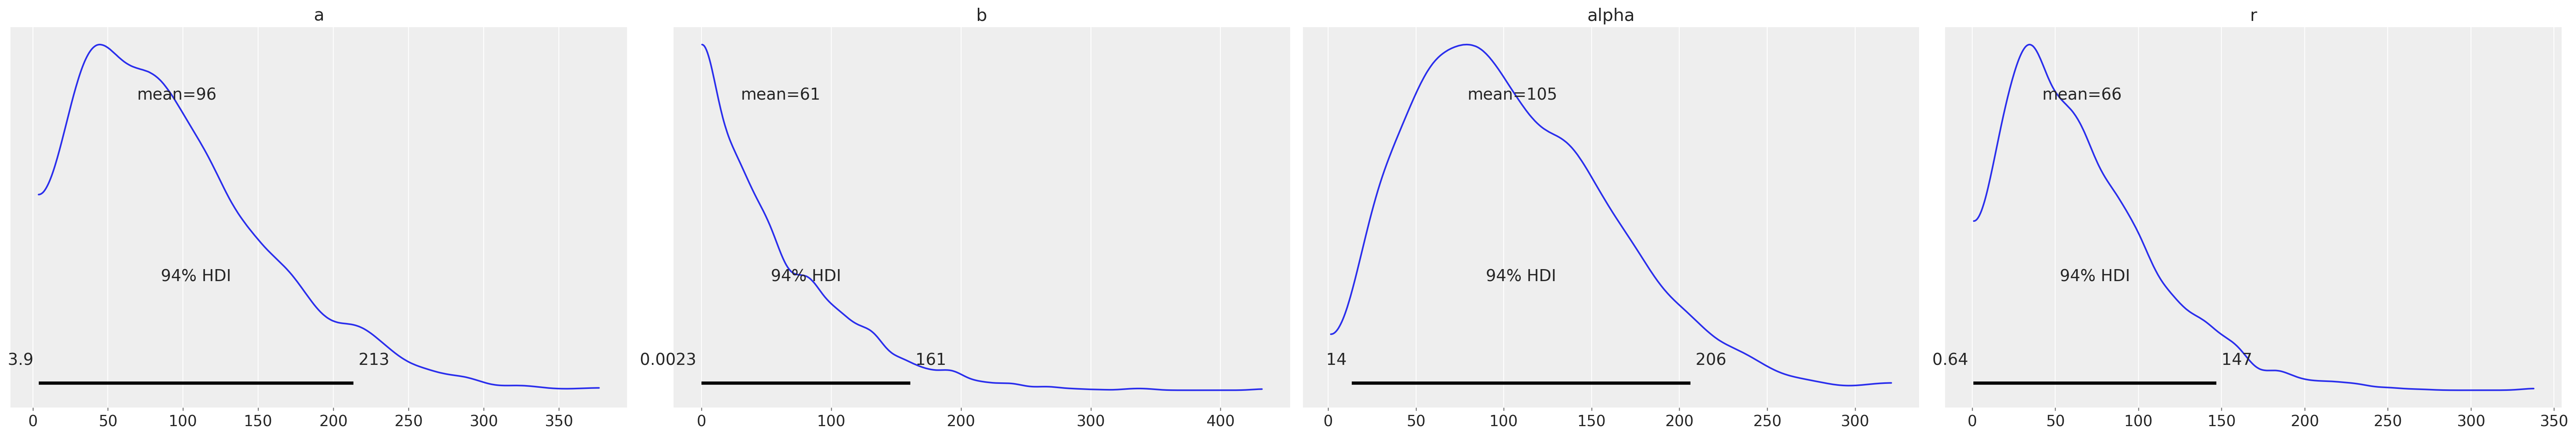

In [33]:
# Visualizing the posterior distributions of the parameters.
# These distributions show the range of probable values for each parameter, considering the observed data.

az.plot_posterior(bgm.fit_result);

The spread of the distributions indicates the uncertainty in the estimates. Narrower distributions suggest more precise estimates.

### Visualizing the Frequency/Recency Matrix

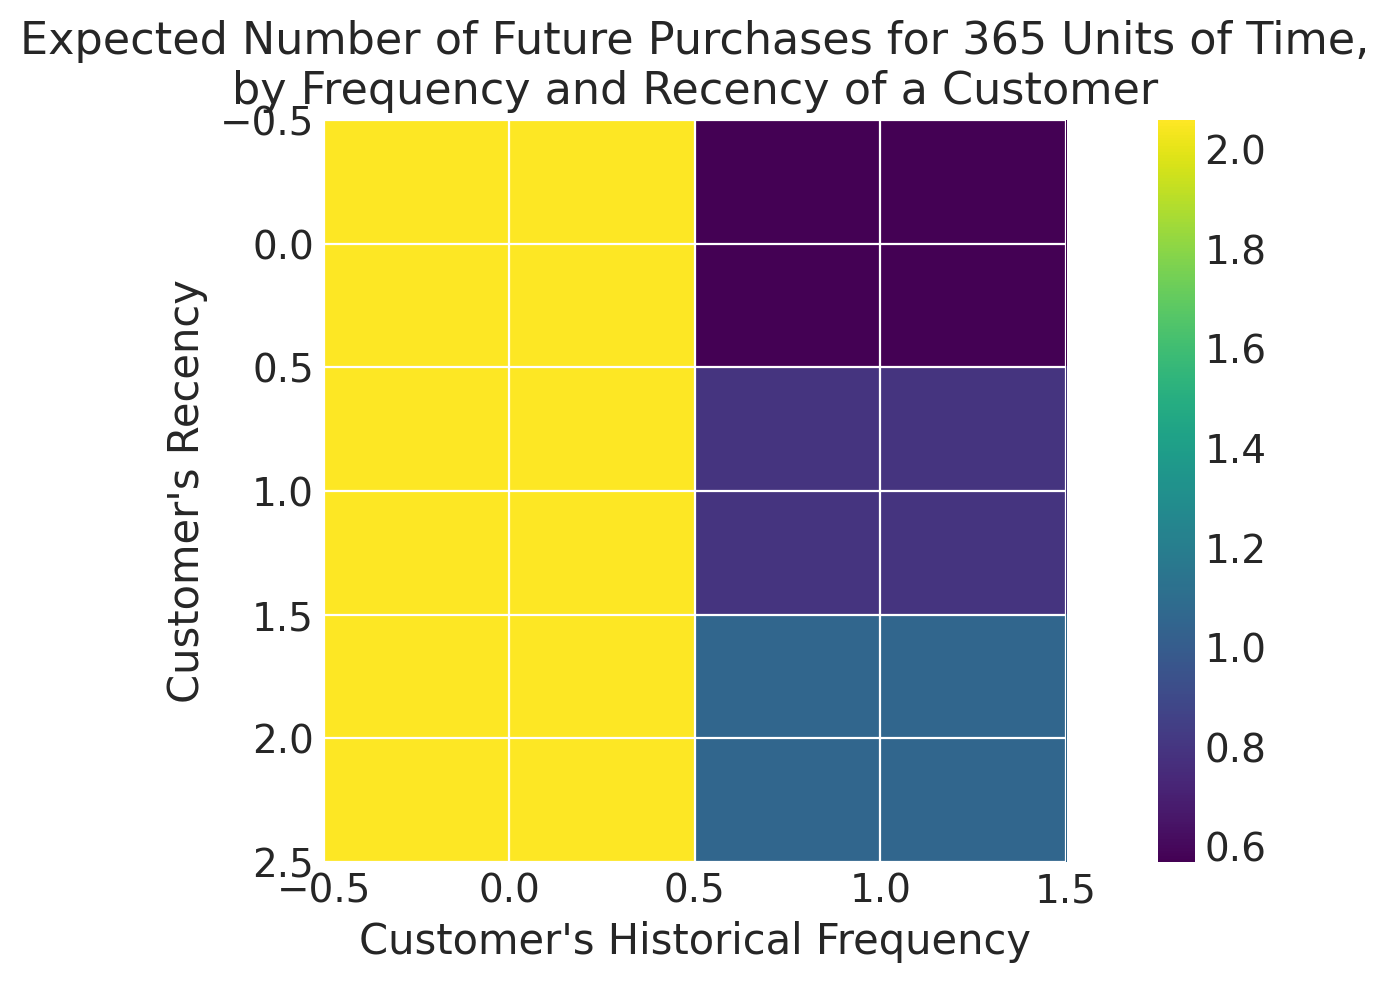

In [34]:
# Analyzing customer behavior using a Frequency/Recency matrix, which visualizes customer archetypes.
# This matrix helps in identifying patterns like potentially "at-risk" customers who might churn.

clv.plot_frequency_recency_matrix(bgm, t=365);

Observations from the matrix can guide strategies to possibly re-engage fading customers or reward loyal ones.

Your best customer are those in the bottom-right: They have bought frequently and they are still buying. Your "coldest" customers are those that are in the top-right corner: they bought a lot quickly, and we haven’t seen them in weeks.

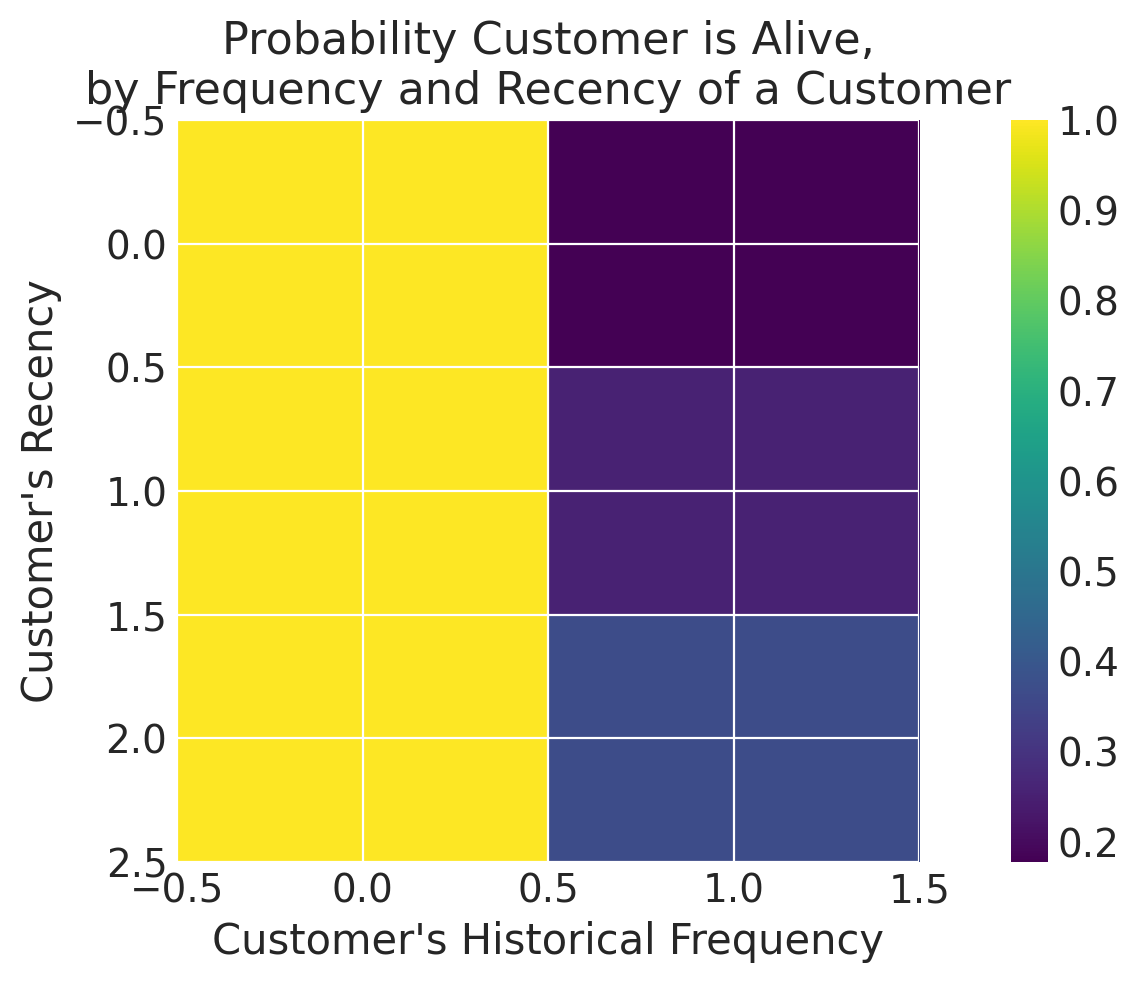

In [35]:
# The Probability Alive Matrix visualizes the likelihood of customers still being active. This view is essential for identifying potentially lost customers and understanding overall customer retention.

clv.plot_probability_alive_matrix(bgm);

Looking at the probability alive matrix, we can infer that users who have made a lot of purchases a long time ago are likely to never return.

### Predict the number of purchases

In [36]:
# Predicting future purchases within the next 365 days using the fitted model.

num_purchases = bgm.expected_num_purchases(
    customer_id=data_summary_rfm["customer_id"],
    t=365,
    frequency=data_summary_rfm["frequency"],
    recency=data_summary_rfm["recency"],
    T=data_summary_rfm["T"]
)

In [37]:
# We add expected purchases to our data summary and display the customers with the highest expected purchases.

sdata = data_summary_rfm.copy()
sdata["expected_purchases"] = num_purchases.mean(("chain", "draw")).values
sdata.sort_values(by="expected_purchases").tail(4)

,customer_id,frequency,recency,T,monetary_value,expected_purchases
customer_id,,,,,,
18484138,18484138,1.0,2.0,72.0,300.0,0.00224


/usr/local/lib/python3.10/dist-packages/arviz/plots/plot_utils.py:141: UserWarning: The number of rows times columns is larger than necessary
  warnings.warn("The number of rows times columns is larger than necessary")


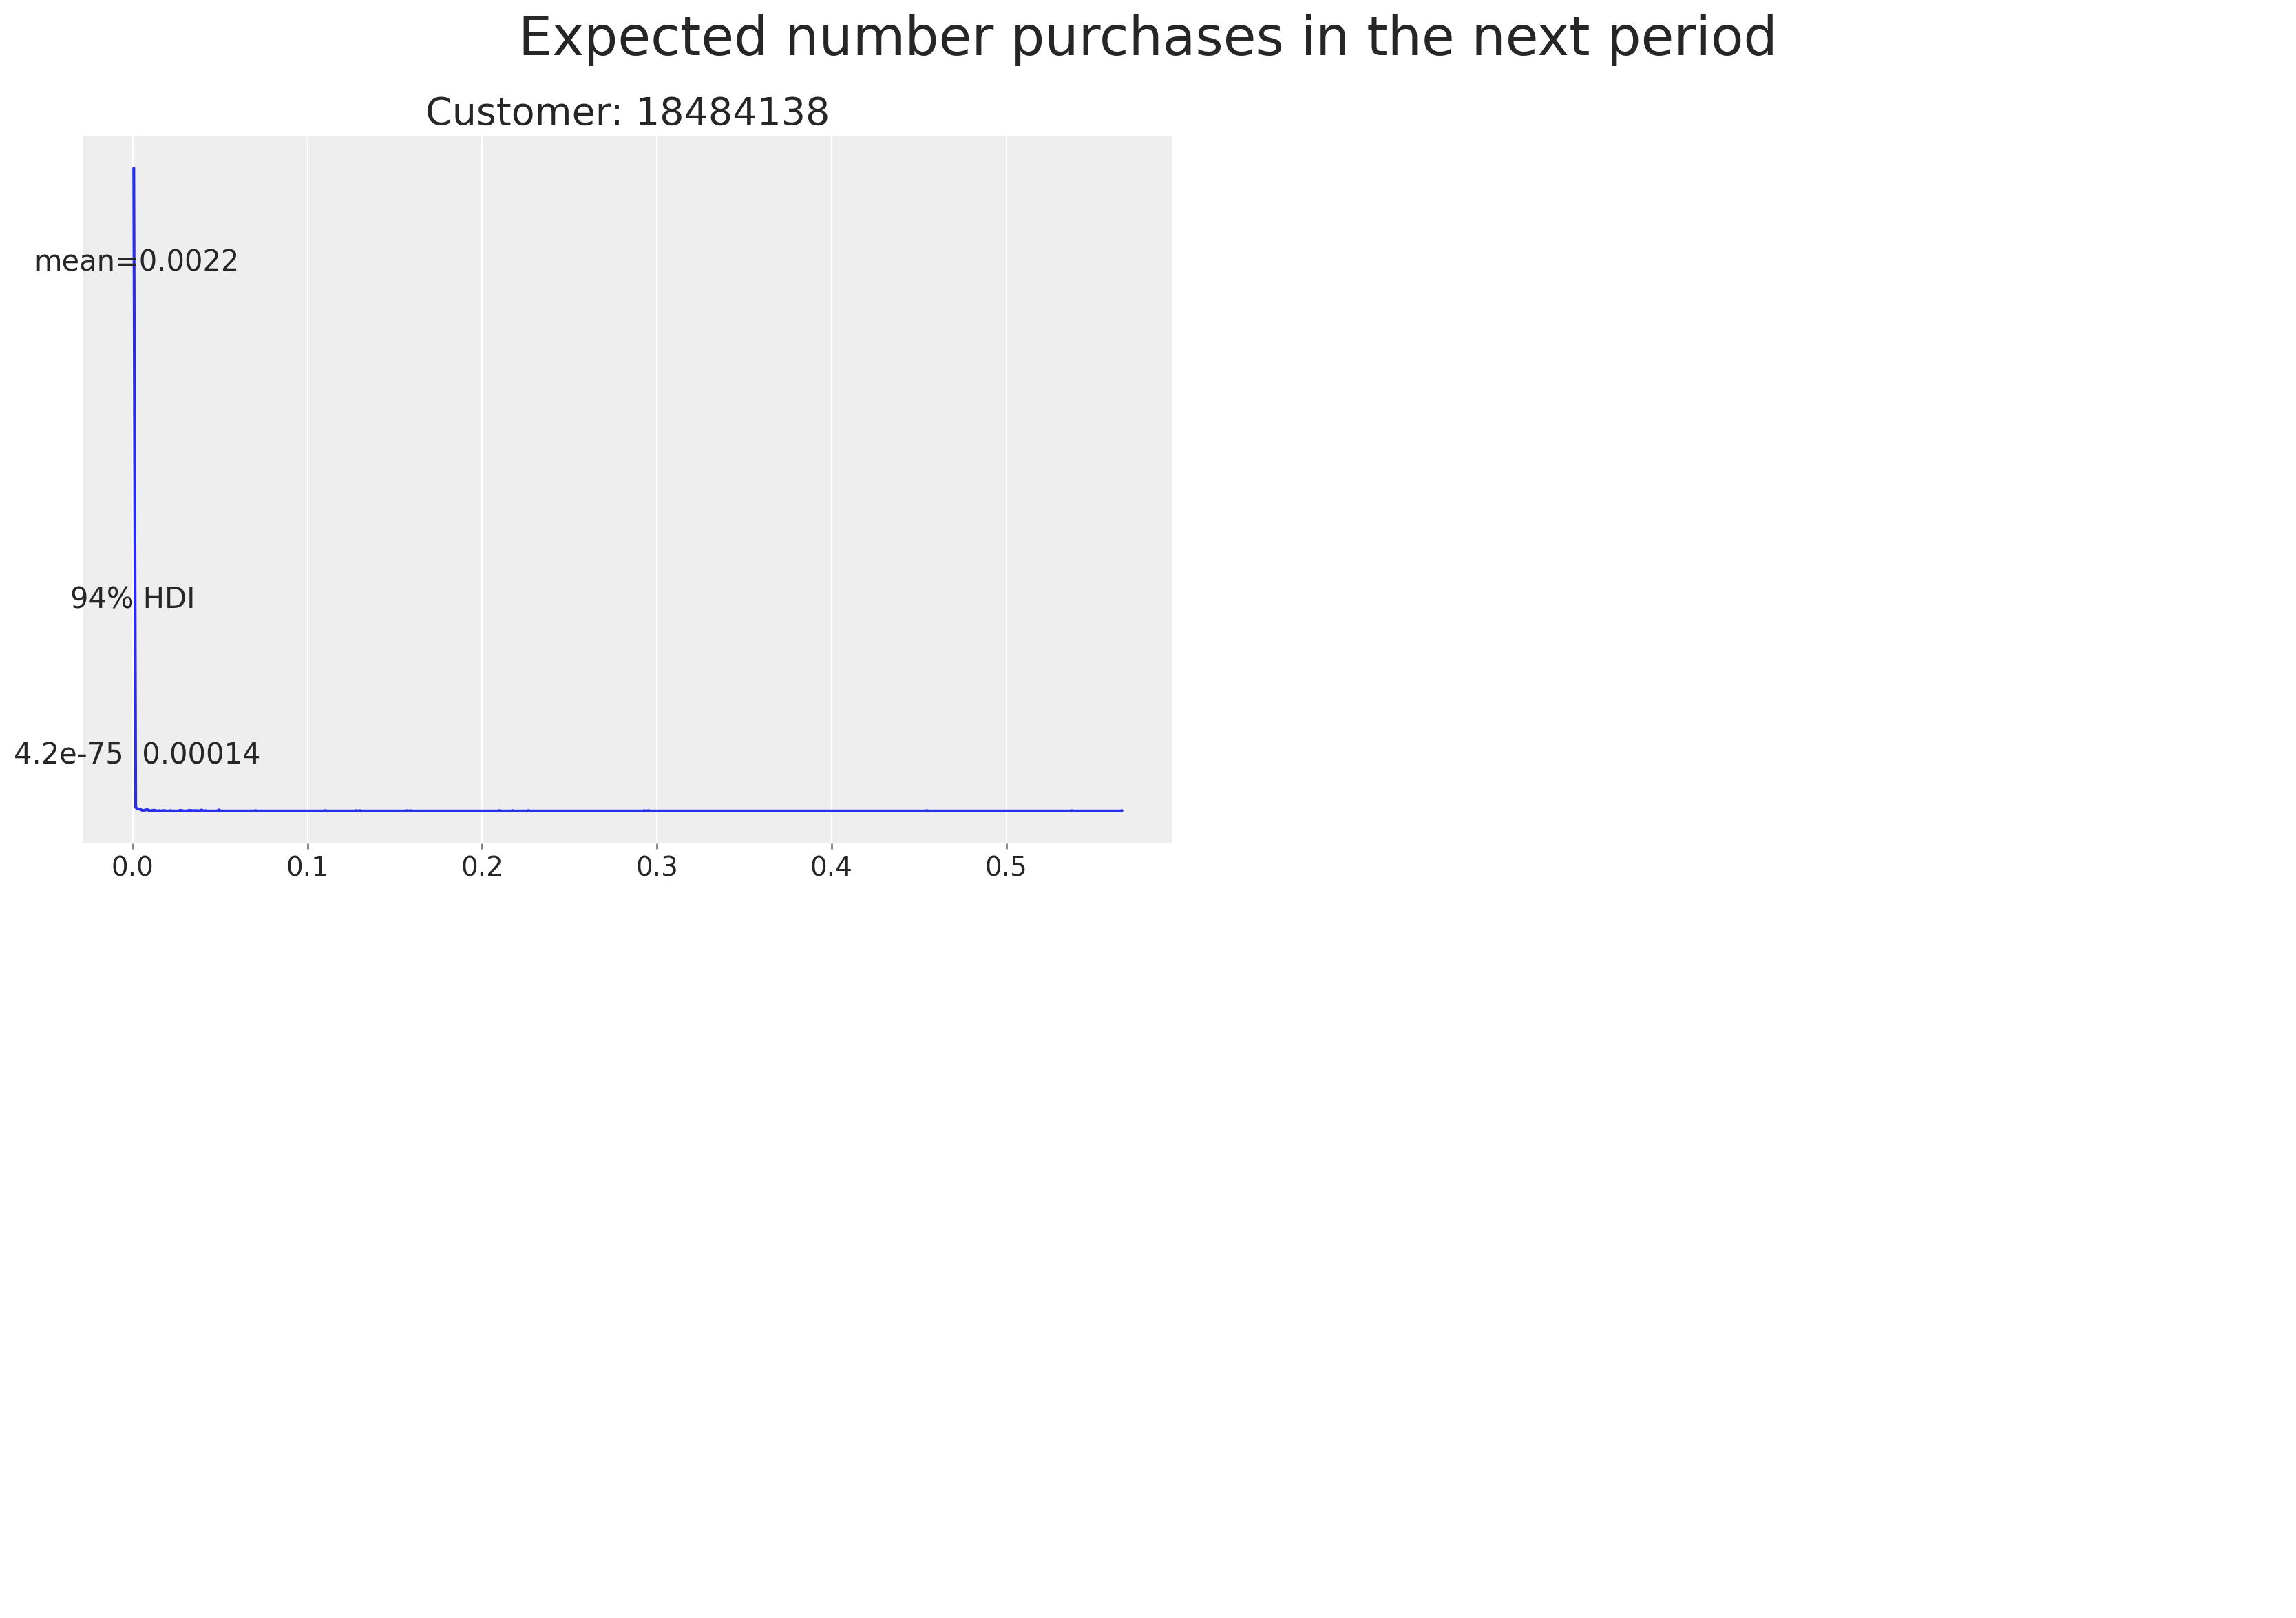

In [38]:
# Here, we're visualizing the uncertainty in our predictions for the number of purchases.
# This step illustrates the range of likely outcomes, highlighting the probabilistic nature of our predictions.

ids = sdata.sort_values(by="expected_purchases", ascending=False).head(4)['customer_id'].tolist()
ax = az.plot_posterior(num_purchases.sel(customer_id=ids), grid=(2, 2));
for axi, id in zip(ax.ravel(), ids):
    axi.set_title(f"Customer: {id}", size=20)
plt.suptitle("Expected number purchases in the next period", fontsize=28, y=1.05);

### Predicting purchase behavior of a new customer

We can use the fitted model to predict the number of purchases for a fresh new customer.

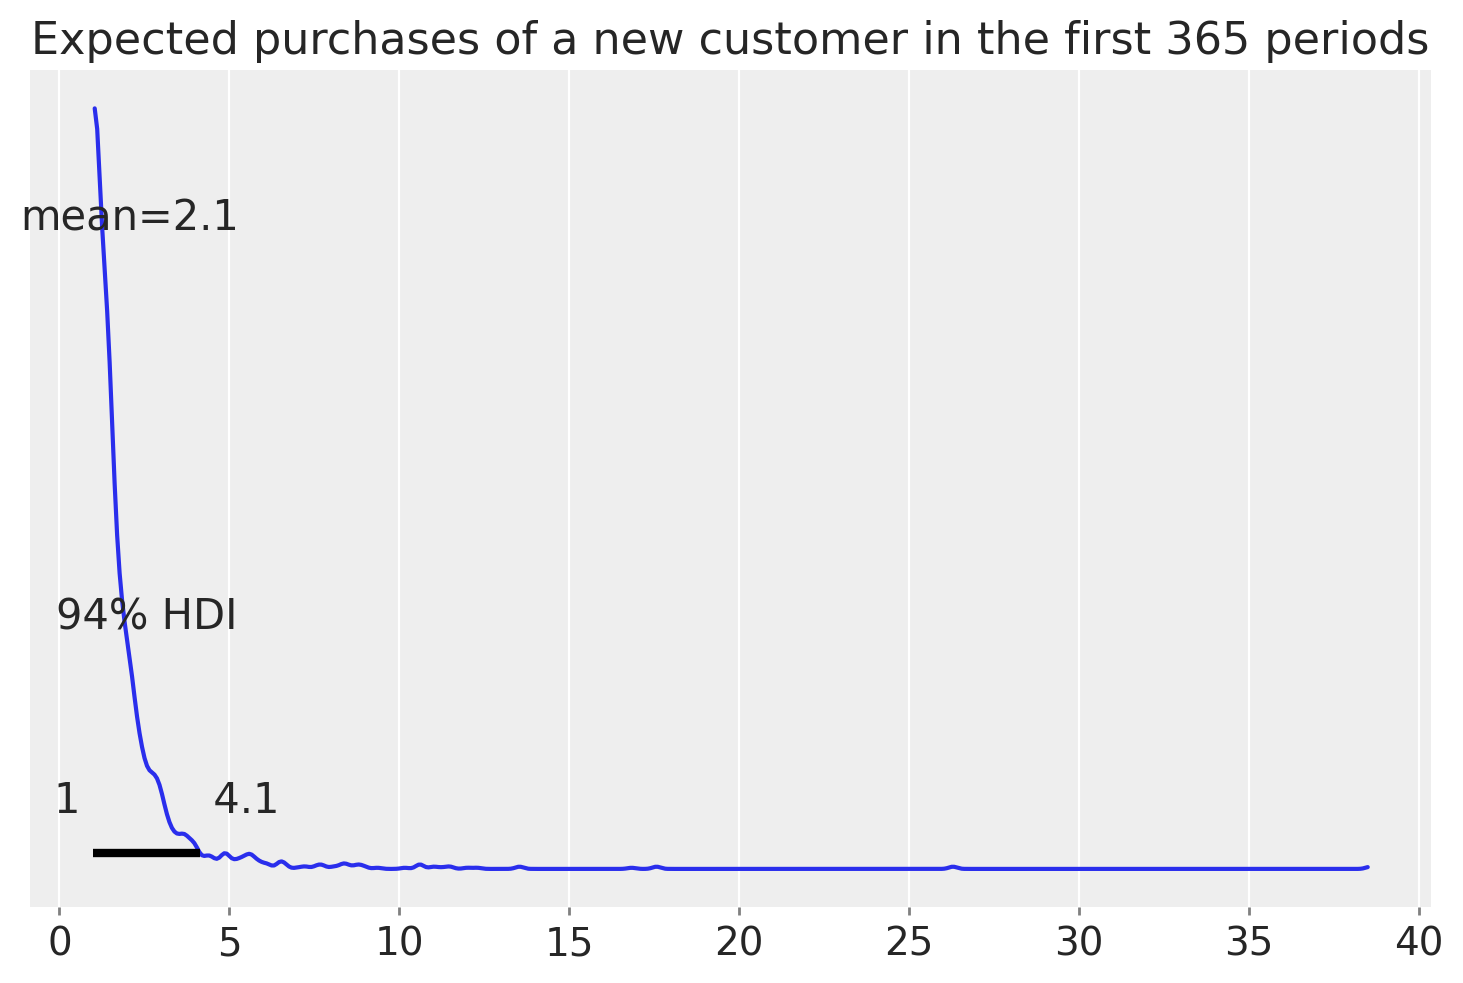

In [39]:
# Estimating the purchasing behavior of a completely new customer.
# This prediction is useful for understanding what purchasing behavior might be expected from prospective customers.

az.plot_posterior(
    bgm.expected_num_purchases_new_customer(t=365)
);
plt.title("Expected purchases of a new customer in the first 365 periods");

### Customer Probability Histories

Given a customer transaction history, we can calculate their historical probability of being alive, according to our trained model.

In [41]:
# Selecting a specific customer to visualize their transaction history and model their future transaction probability.

customer_id_viz = '18484138'
customer_viz = data_summary_rfm.loc[customer_id_viz]
customer_viz  # Displaying the selected customer's historical summary.

customer_id       18484138
frequency              1.0
recency                2.0
T                     72.0
monetary_value       300.0
Name: 18484138, dtype: object

In [42]:
# Constructing a hypothetical future transaction history for the selected customer over a set period (30 units of time).

data_range = 30
customer_viz_history = pd.DataFrame(dict(
    ID=np.full(data_range, customer_id_viz, dtype="int"),
    frequency=np.full(data_range, customer_viz["frequency"], dtype="int"),
    recency=np.full(data_range, customer_viz["recency"]),
    T=(np.arange(-1, data_range-1) + customer_viz["T"]).astype("int"),

))
customer_viz_history # Viewing the constructed future transaction history.

,ID,frequency,recency,T
0,18484138,1,2.0,71
1,18484138,1,2.0,72
2,18484138,1,2.0,73
3,18484138,1,2.0,74
4,18484138,1,2.0,75
5,18484138,1,2.0,76
6,18484138,1,2.0,77
7,18484138,1,2.0,78
8,18484138,1,2.0,79
9,18484138,1,2.0,80


In [43]:
# Calculating the probability of this customer being still active (alive) using the BG/NBD model.
# This step predicts the likelihood of the customer returning for future purchases based on their transaction history.

p_alive = bgm.expected_probability_alive(
    customer_id=customer_viz_history["ID"],
    frequency=customer_viz_history["frequency"],
    recency=customer_viz_history["recency"],
    T=customer_viz_history["T"],
)

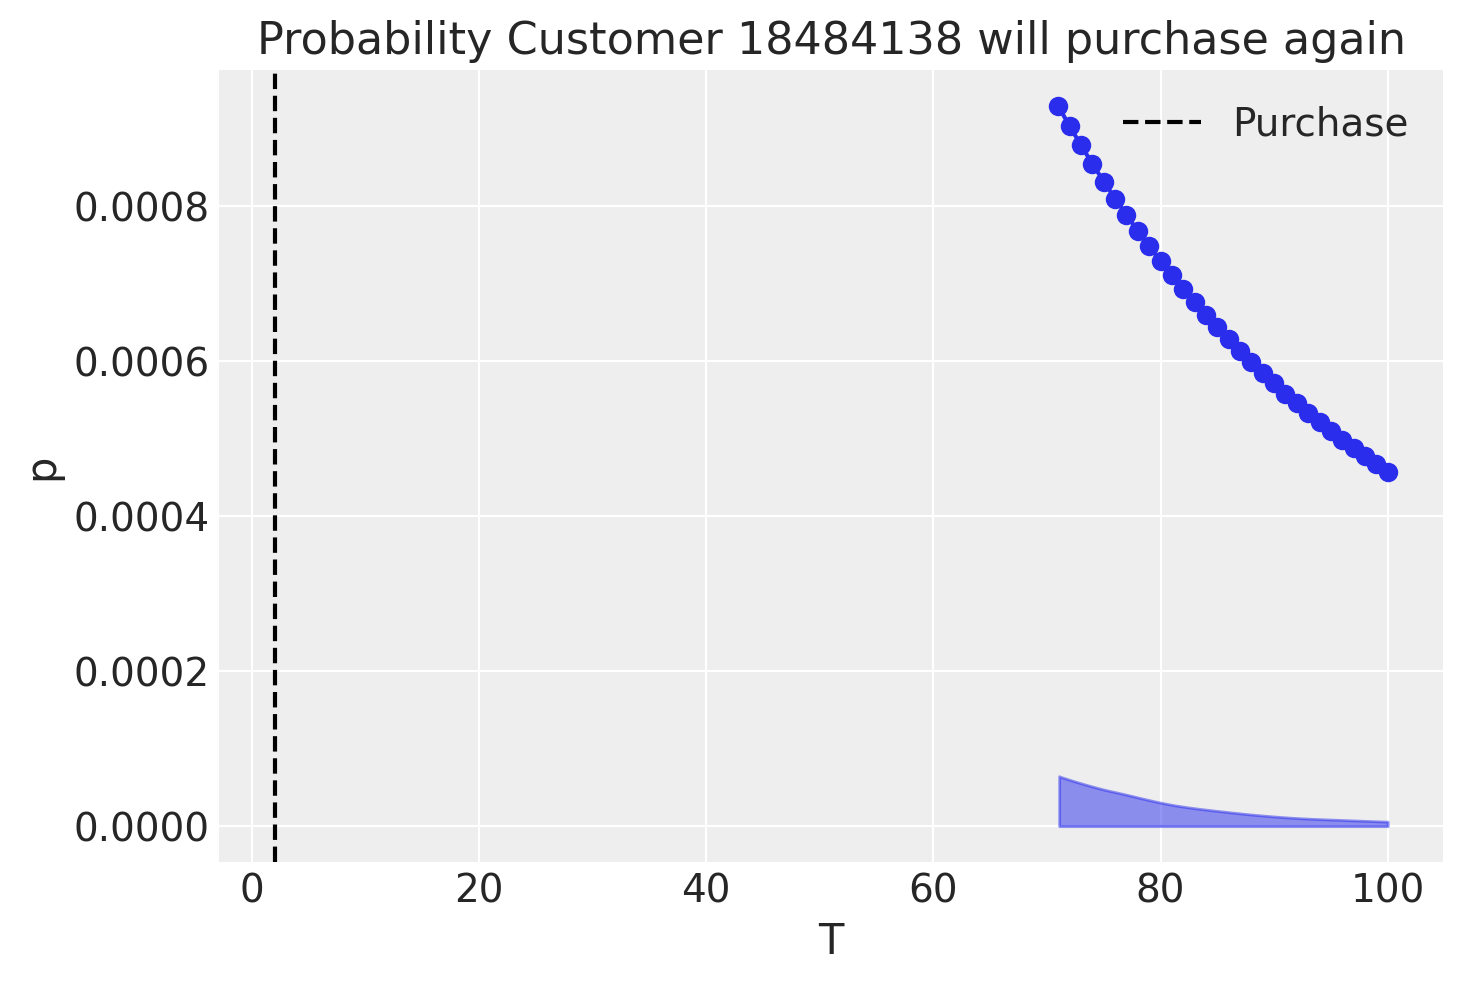

In [44]:
# Visualizing the customer's probability of remaining active over the forecasted period.
# The shaded area represents the confidence interval, providing a range where the actual probability is likely to fall.

az.plot_hdi(customer_viz_history["T"], p_alive, color="C0")
plt.plot(customer_viz_history["T"], p_alive.mean(("draw", "chain")), marker="o")
plt.axvline(customer_viz_history["recency"].iloc[0], c="black", ls="--", label="Purchase")

plt.title(f"Probability Customer {customer_id_viz} will purchase again")
plt.xlabel("T")
plt.ylabel("p")
plt.legend();

Note: The plot suggests that the likelihood of a customer returning decreases the longer they go without making a purchase.

In [45]:
# Now, let's simulate a scenario where the customer makes an additional purchase during the forecast period.
# We adjust the customer's transaction history to reflect this new purchase and observe its impact on their active probability.

customer_viz_history["frequency"].iloc[-10:] += 1
customer_viz_history["recency"].iloc[-10:] = customer_viz_history["T"].iloc[-10] - 0.5
customer_viz_history

<ipython-input-45-fe8a9ae114c7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_viz_history["frequency"].iloc[-10:] += 1
<ipython-input-45-fe8a9ae114c7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_viz_history["recency"].iloc[-10:] = customer_viz_history["T"].iloc[-10] - 0.5


,ID,frequency,recency,T
0,18484138,1,2.0,71
1,18484138,1,2.0,72
2,18484138,1,2.0,73
3,18484138,1,2.0,74
4,18484138,1,2.0,75
5,18484138,1,2.0,76
6,18484138,1,2.0,77
7,18484138,1,2.0,78
8,18484138,1,2.0,79
9,18484138,1,2.0,80


In [46]:
# Recalculating the probability of being alive based on the updated transaction history.

p_alive = bgm.expected_probability_alive(
    customer_id=customer_viz_history["ID"],
    frequency=customer_viz_history["frequency"],
    recency=customer_viz_history["recency"],
    T=customer_viz_history["T"],
)

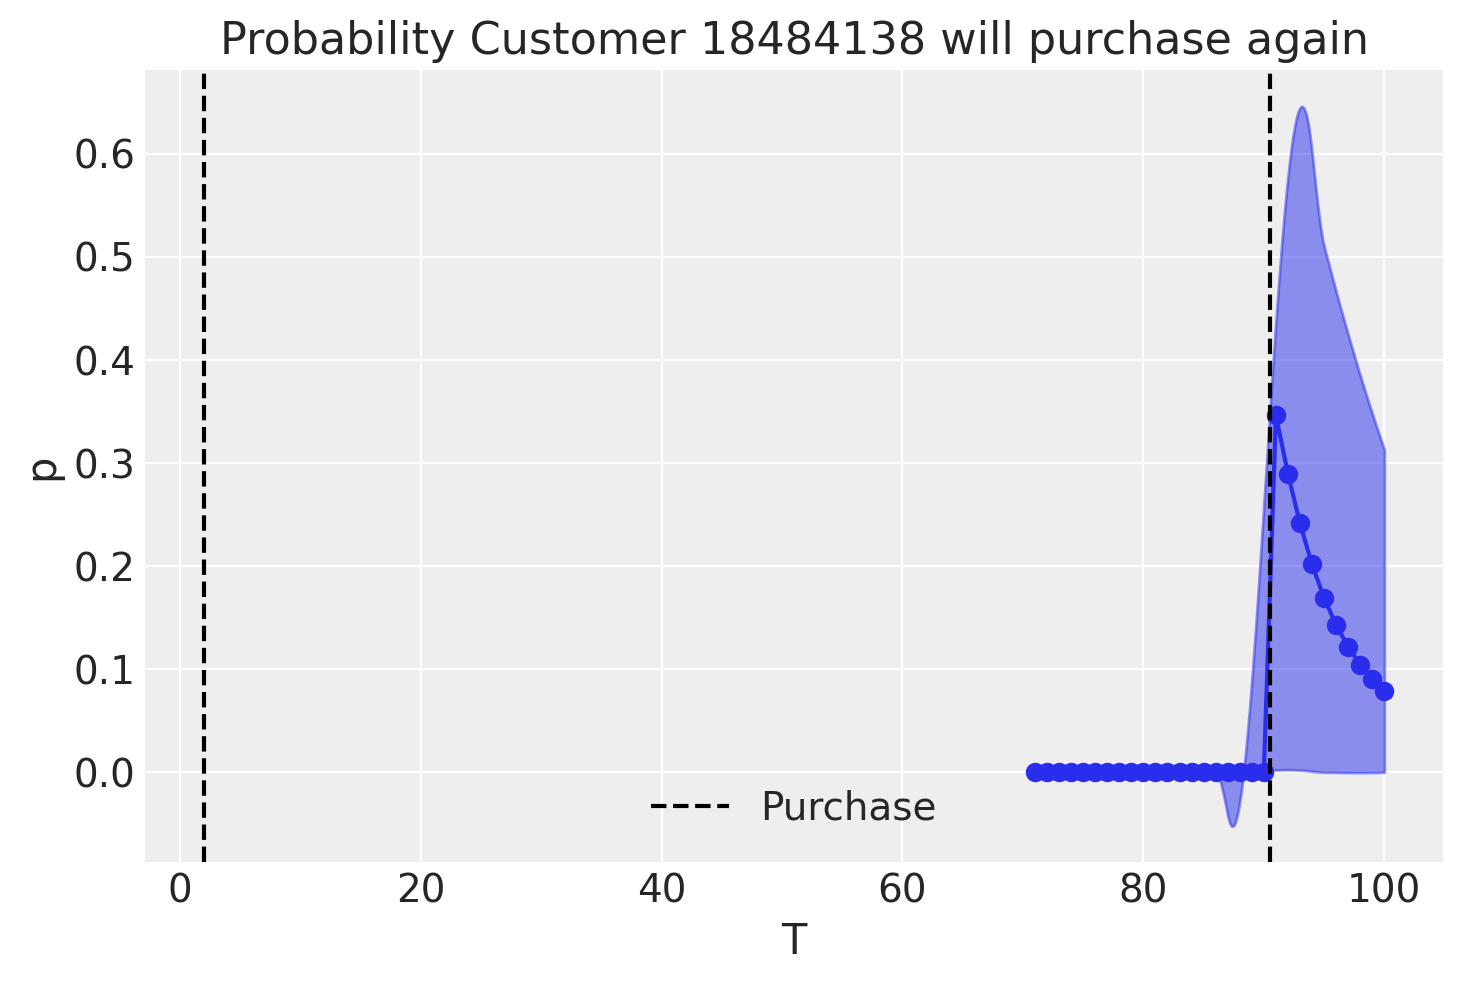

In [47]:
# Plotting the revised probability of the customer remaining active.
# The new purchase is marked, indicating its positive impact on the customer's likelihood of returning for more purchases.

az.plot_hdi(customer_viz_history["T"], p_alive, color="C0")
plt.plot(customer_viz_history["T"], p_alive.mean(("draw", "chain")), marker="o")
plt.axvline(customer_viz_history["recency"].iloc[0], c="black", ls="--", label="Purchase")
plt.axvline(customer_viz_history["recency"].iloc[-1], c="black", ls="--")

plt.title(f"Probability Customer {customer_id_viz} will purchase again")
plt.xlabel("T")
plt.ylabel("p")
plt.legend();

From the plot above, say that this customer makes a purchase at week 36.5, roughly ~6 weeks after they have made their last recorded purchase at time 30.86 weeks according to the data. We can see that the probability of the customer returning quickly goes back up!

In other words, for every purchase, the probability of a customer returning for a/more purchase(s) increases. Similarly, as time goes by where a customer makes no purchase, the likelihood of them returning for a purchases decreases with time.

# Gamma-Gamma model


The Gamma-Gamma model is now used to estimate the monetary value aspect of customer lifetime value (CLV).
This model assumes that while customers have different average transaction values, the variation in transaction value among transactions is independent of the variation between customers.


In [48]:
# Filtering out customers with zero frequency to fit the Gamma-Gamma model.
# This model requires customers to have made at least one repeat purchase.

nonzero_data = data_summary_rfm.query("frequency>0")
nonzero_data

,customer_id,frequency,recency,T,monetary_value
customer_id,,,,,
18484138,18484138,1.0,2.0,72.0,300.0


The Gamma-Gamma model takes in a 'data' parameter, a pandas DataFrame with 3 columns that contain the group expected average order value and expected individual variation around that mean. As with the BG/NBD model, these parameters are given HalfFlat priors which can be too diffuse for small datasets. For this example, we will use the default priors, but other priors can be specified just like with the BG/NBD example above.

In [49]:
# Preparing the data for the Gamma-Gamma model. This model predicts the average transaction value for each customer,
# given the number of transactions they have made (frequency) and their average transaction value so far.

dataset = pd.DataFrame({
    'customer_id': nonzero_data.customer_id,
    'mean_transaction_value': nonzero_data["monetary_value"],
    'frequency': nonzero_data["frequency"],
})

In [50]:
# Initializing the Gamma-Gamma model with the prepared data.

gg = clv.GammaGammaModel(
    data = dataset
)
gg.build_model()
gg

Gamma-Gamma Model (Mean Transactions)
         p ~ HalfFlat()
         q ~ HalfFlat()
         v ~ HalfFlat()
likelihood ~ Potential(f(q, p, v))

By default, `fit` approximates full Bayesian posterior using [MCMC](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) sampling provided by `pymc.sample`. If the full posterior is not needed or MCMC sampling is too slow, users can obtain the single [maximum a posteriori estimate](https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation) via the `fit_method` kwarg.

In [51]:
# Fitting the Gamma-Gamma model to the data.
# Instead of full Bayesian inference which can be computationally intensive, we're using maximum a posteriori (MAP) estimation.
# MAP provides a good point estimate faster, especially useful for large datasets or when computational resources are limited.

gg.fit(fit_method="map");

In [52]:
# After fitting, we examine the model's summary and posterior distributions to understand the estimated parameters' characteristics.

gg.fit_summary()

p    9.413586e+12
q    1.640475e+13
v    5.228000e+02
Name: value, dtype: float64

In [53]:
gg.fit();

In [54]:
# Displaying a summary of the model's fit to understand the estimated parameters' characteristics better.
# This summary provides insights into the convergence of the model and the reliability of its predictions.

gg.fit_summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,5.237538e+03,4.061541e+03,1.177012e+03,9.298063e+03,2.860432e+03,2.419796e+03,3.0,29.0,2.15
q,3.786670e+15,2.858749e+15,9.286358e+14,6.644704e+15,2.013339e+15,1.703193e+15,2.0,9.0,2.45
v,8.551199e+14,8.252256e+14,3.010066e+13,1.680139e+15,5.811838e+14,4.916551e+14,2.0,22.0,2.67


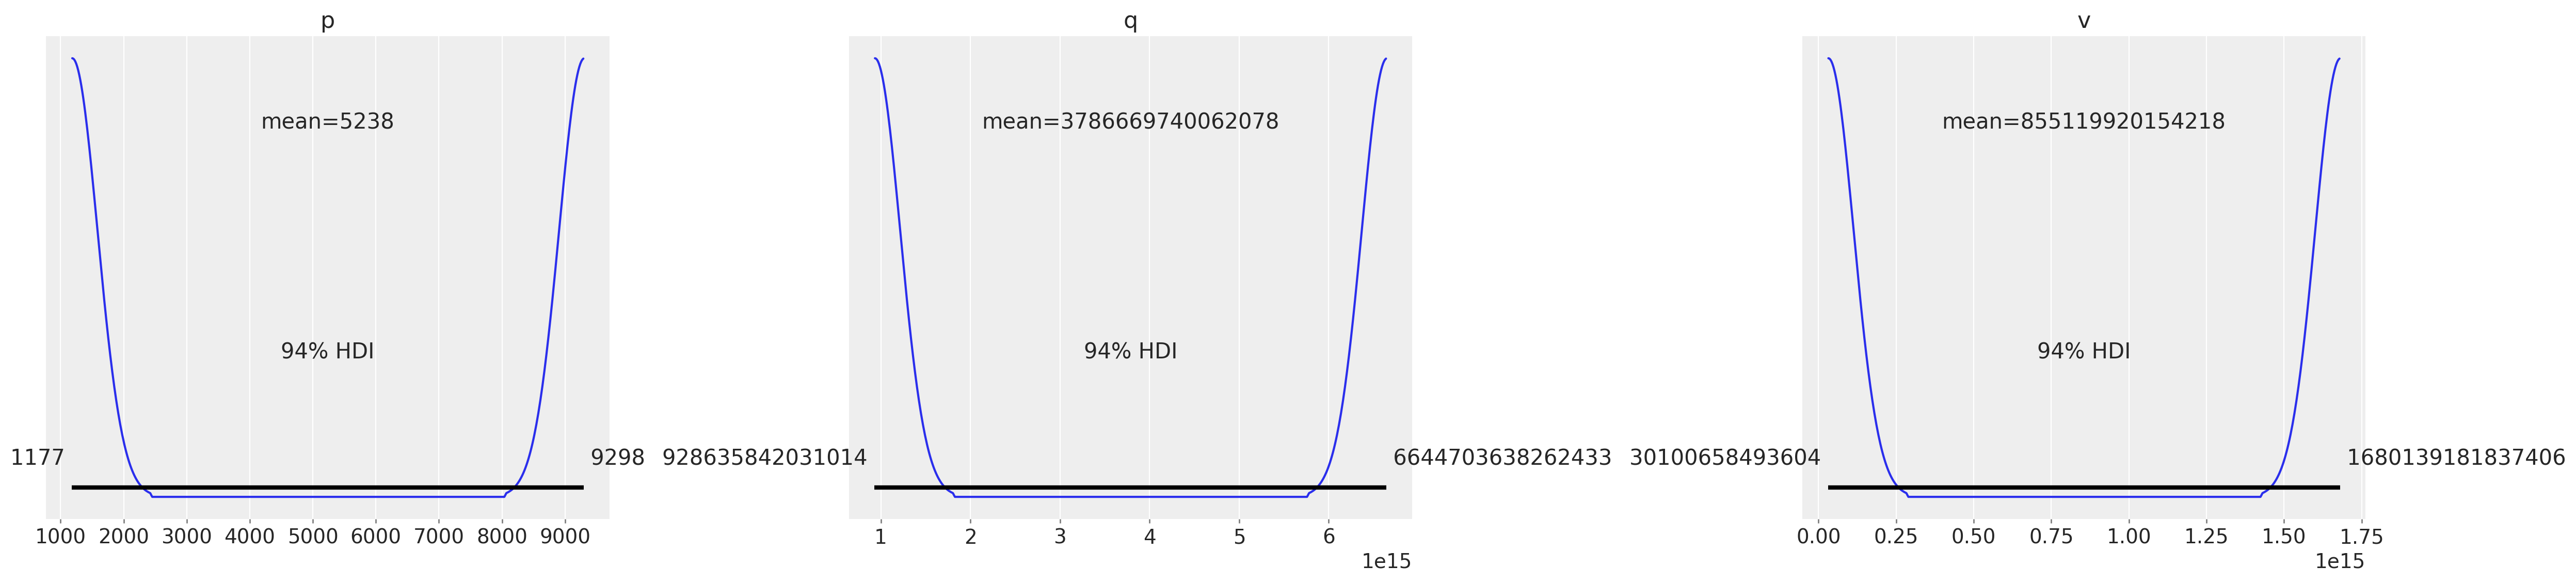

In [55]:
# Visualizing the posterior distributions of the estimated parameters using ArviZ.
# These plots help us assess the uncertainty surrounding our estimates, which is crucial for informed decision-making.

az.plot_posterior(gg.fit_result);

### Predicting Customer Spending

Having fit our model, we can now use it to predict the conditional, expected average lifetime value of our customers, including those with zero repeat purchases.

In [56]:
# Calculating the conditional expected average order value for each customer.

expected_spend = gg.expected_customer_spend(
    customer_id=data_summary_rfm["customer_id"],
    mean_transaction_value=data_summary_rfm["monetary_value"],
    frequency=data_summary_rfm["frequency"],
)

In [58]:
# Summarizing the expected statistics of average order value for the first ten customers.

#az.summary(expected_spend.isel(customer_id=range(10)), kind="stats")
az.summary(expected_spend.isel(customer_id=range(1)), kind="stats")

,mean,sd,hdi_3%,hdi_97%
x[18484138],299.499,1.887,297.612,301.386


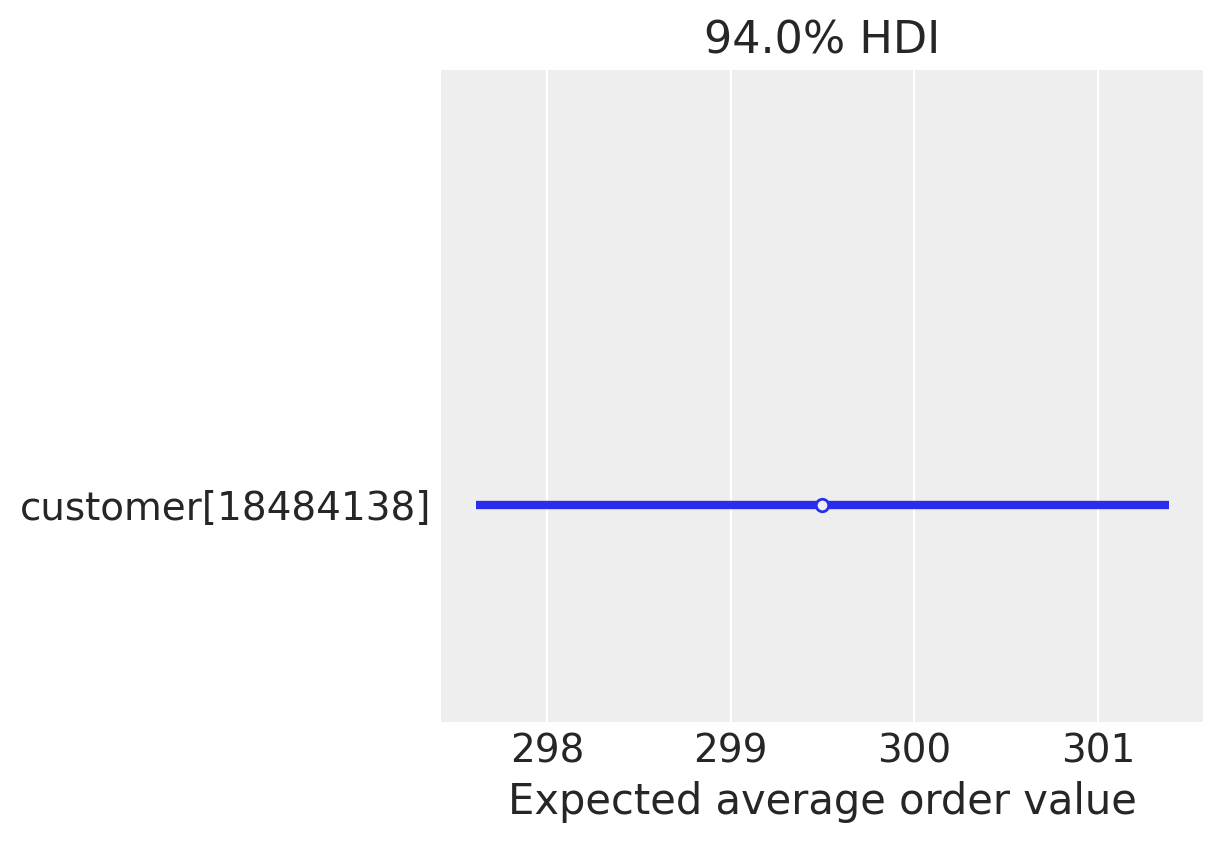

In [59]:
# Creating a forest plot to visualize the expected spend across customers.

labeller = MapLabeller(var_name_map={"x": "customer"})
#az.plot_forest(expected_spend.isel(customer_id=(range(5))), combined=True, labeller=labeller)
az.plot_forest(expected_spend.isel(customer_id=(range(1))), combined=True, labeller=labeller)
plt.xlabel("Expected average order value");

We can also look at the average expected average order value across all customers

In [60]:
# Analyzing the overall average expected spend across all customers.
# This aggregate metric provides a broad view, useful for strategic planning and overall revenue forecasting.

az.summary(expected_spend.mean("customer_id"), kind="stats")

,mean,sd,hdi_3%,hdi_97%
x,299.499,1.887,297.612,301.386


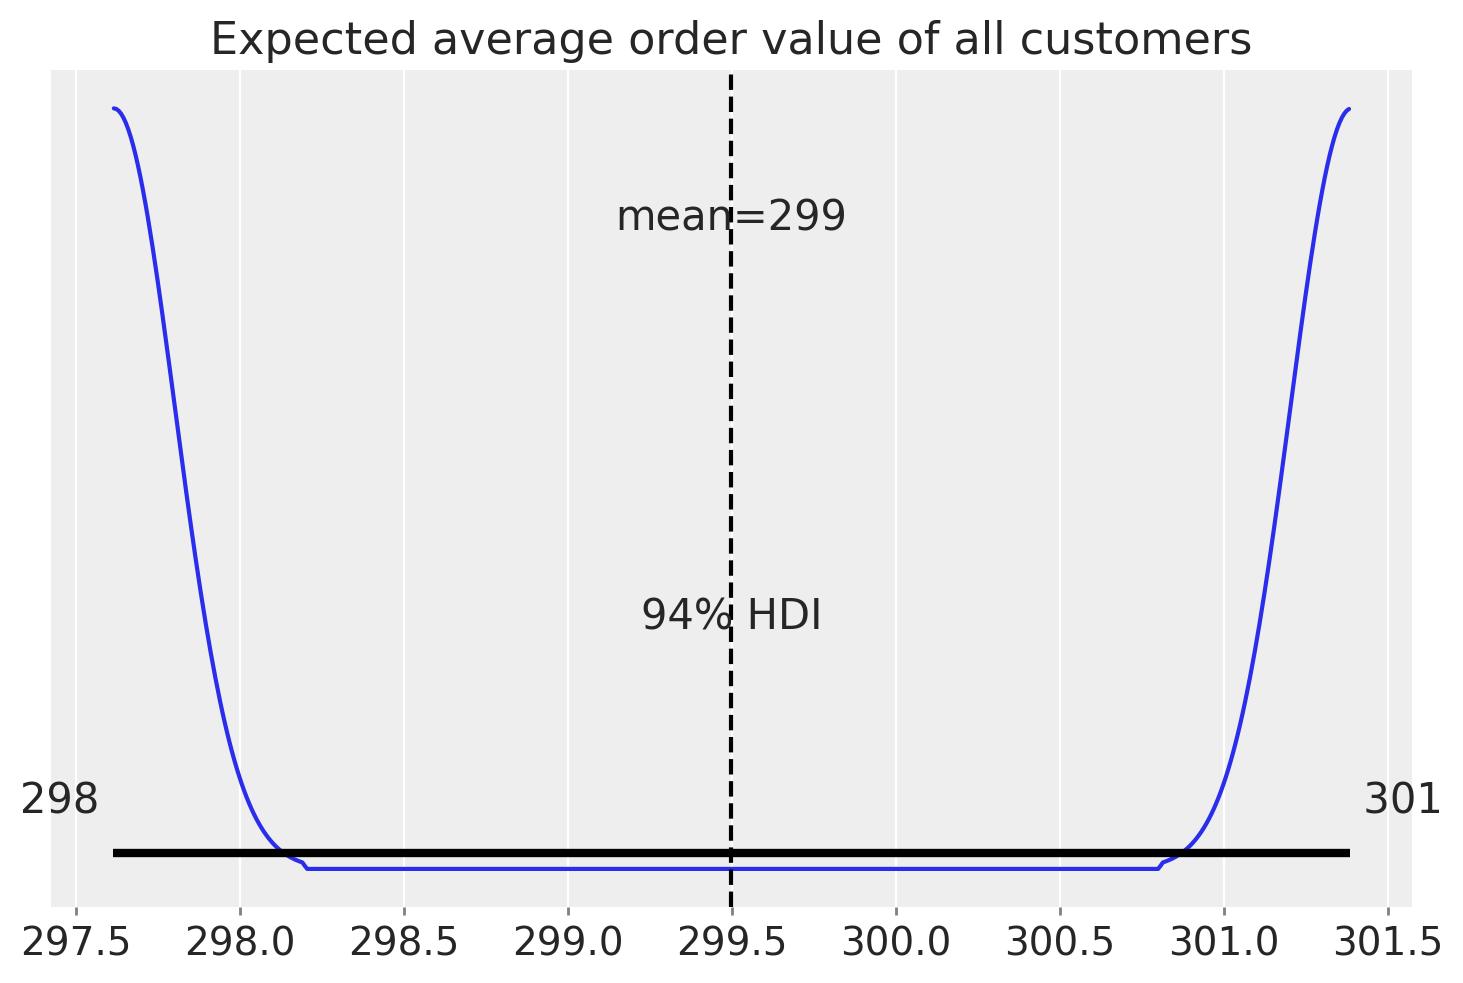

In [61]:
# Plotting the posterior distribution of the average expected spend for all customers.
# The vertical line represents the mean, giving a reference point against the distribution spread.

az.plot_posterior(expected_spend.mean("customer_id"))
plt.axvline(expected_spend.mean(), color="k", ls="--")
plt.title("Expected average order value of all customers");

### Predicting New Customer Spending

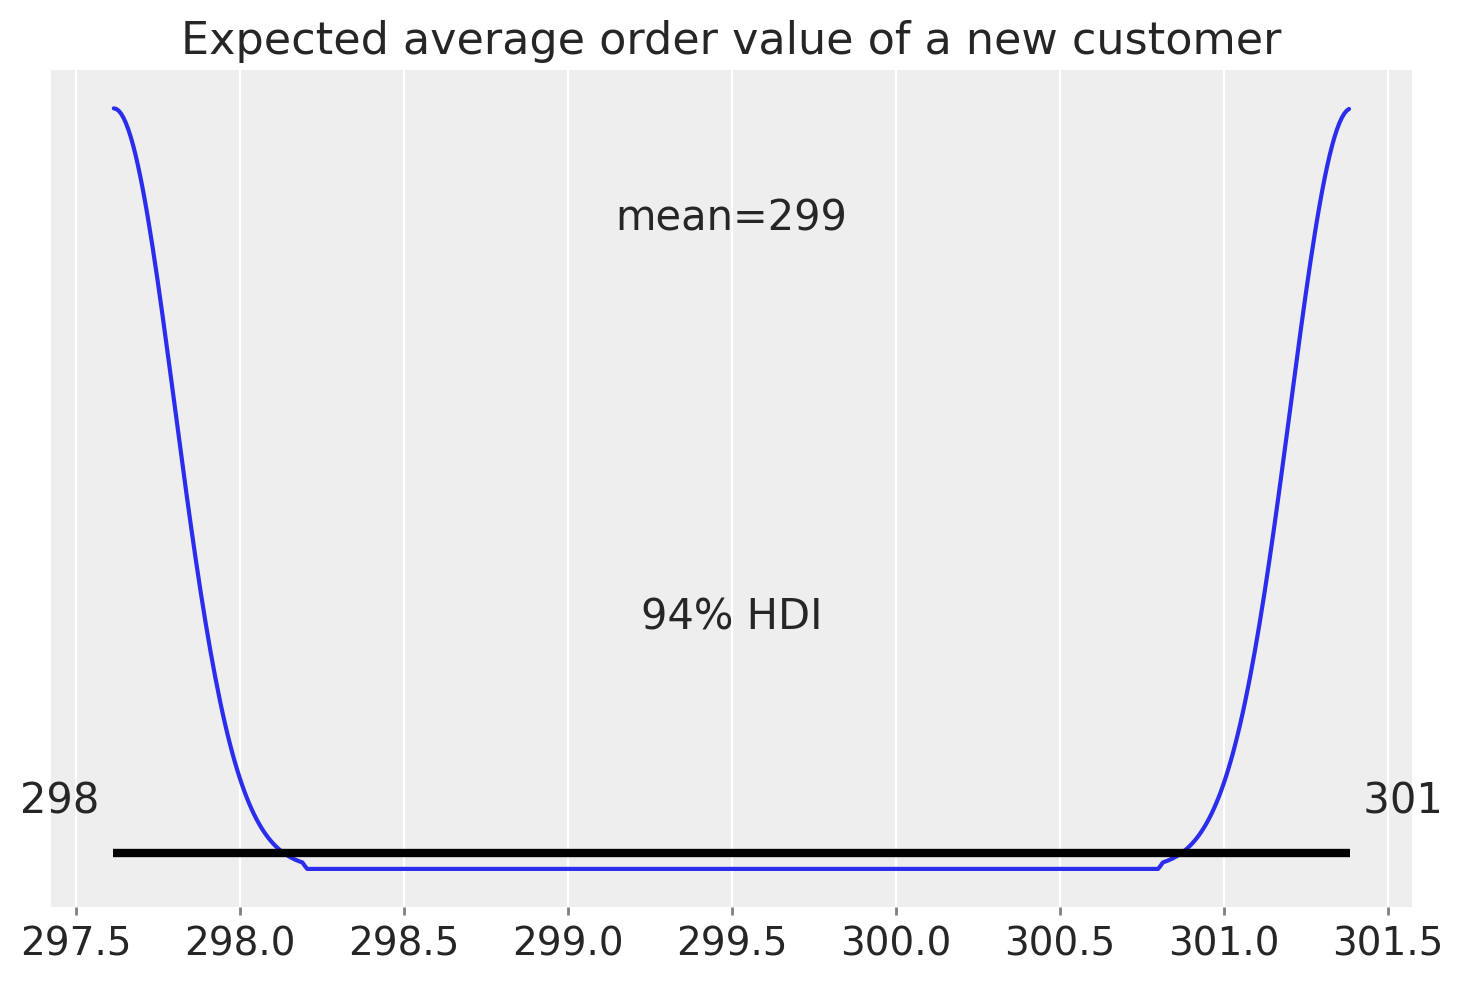

In [62]:
# Estimating the expected average spend of a hypothetical new customer.
# This prediction helps in budgeting and planning marketing strategies for customer acquisition.

az.plot_posterior(
    gg.expected_new_customer_spend()
)

plt.title("Expected average order value of a new customer");

### Customer Lifetime Value (CLV) Estimation

Finally, we can combine the GG with the BG/NBD model to obtain an estimate of the customer lifetime value. This relies on the [Discounted cash flow](https://en.wikipedia.org/wiki/Discounted_cash_flow) model, adjusting for cost of capital:

In [67]:
# Estimating CLV using a Discounted Cash Flow approach, factoring in the time value of money with a discount rate.
# This method captures both the frequency and monetary value dimensions of CLV, offering a nuanced view of customer profitability.

clv_estimate = gg.expected_customer_lifetime_value(
    transaction_model=bgm,
    customer_id=data_summary_rfm['customer_id'],
    mean_transaction_value=data_summary_rfm["monetary_value"],
    frequency=data_summary_rfm["frequency"],
    recency=data_summary_rfm["recency"],
    T=data_summary_rfm["T"],
    time=120, # 120 months = 10 years
    discount_rate=0.01,
    freq="D",
)

/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


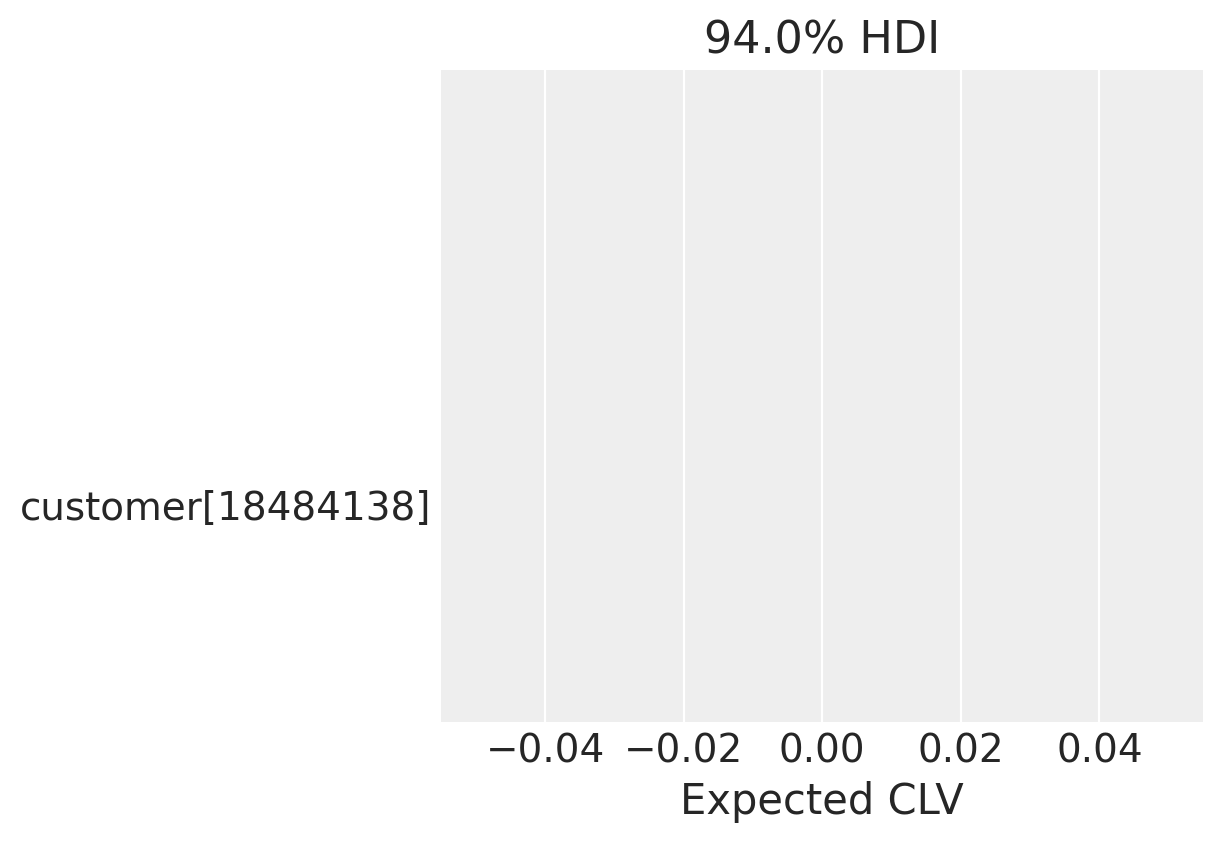

In [68]:
# Visualizing the estimated CLV for a subset of customers.
# The forest plot allows for easy comparison and highlights the variability in the projected CLVs.
#az.plot_forest(clv_estimate.isel(customer_id=range(5)), combined=True, labeller=labeller)
az.plot_forest(clv_estimate.isel(customer_id=range(1)), combined=True, labeller=labeller)
plt.xlabel("Expected CLV");

In [69]:
# Reviewing the detailed CLV estimates, which are crucial inputs for strategic decisions like resource allocation,
# personalized marketing, and customer segmentation strategies.

clv_estimate

<xarray.DataArray (chain: 2, draw: 1000, customer_id: 1)>
array([[[9.18264725e-08],
        [5.89668625e-06],
        [1.00398610e-21],
        ...,
        [1.73958602e-09],
        [2.79312511e-10],
        [1.06394431e-07]],

       [[1.49431424e-11],
        [5.34968496e-17],
        [2.08714261e-03],
        ...,
        [4.91515418e-14],
        [1.34349581e-18],
        [1.16835110e-18]]])
Coordinates:
  * chain        (chain) int64 0 1
  * draw         (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * customer_id  (customer_id) object '18484138'

In [71]:
# Summarizing the expected CLV for the first ten customers.

#az.summary(clv_estimate.isel(customer_id=range(10)), kind="stats")
az.summary(clv_estimate.isel(customer_id=range(1)), kind="stats")

,mean,sd,hdi_3%,hdi_97%
x[18484138],NaN,NaN,0.0,NaN


### Exporting and Analyzing CLV Data

In [73]:
clv_df = az.summary(clv_estimate, kind="stats").reset_index()

clv_df['customer_id'] = clv_df['index'].str.extract('(\d+)')[0]

clv_df = clv_df[['customer_id', 'mean', 'hdi_3%', 'hdi_97%']]
clv_df.rename(columns={'mean' : 'clv_estimate', 'hdi_3%': 'clv_estimate_hdi_3%', 'hdi_97%': 'clv_estimate_hdi_97%'}, inplace=True)

# monetary_values = data_summary_rfm.loc[clv_df['customer_id'], 'monetary_value']
monetary_values = data_summary_rfm.set_index('customer_id').loc[clv_df['customer_id'], 'monetary_value']
clv_df['monetary_value'] = monetary_values.values
clv_df.to_csv('clv_estimates_output.csv', index=False)
pd.read_csv('clv_estimates_output.csv')

,customer_id,clv_estimate,clv_estimate_hdi_3%,clv_estimate_hdi_97%,monetary_value
0,18484138,NaN,0.0,NaN,300.0


<ipython-input-74-cf744ce05f30>:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


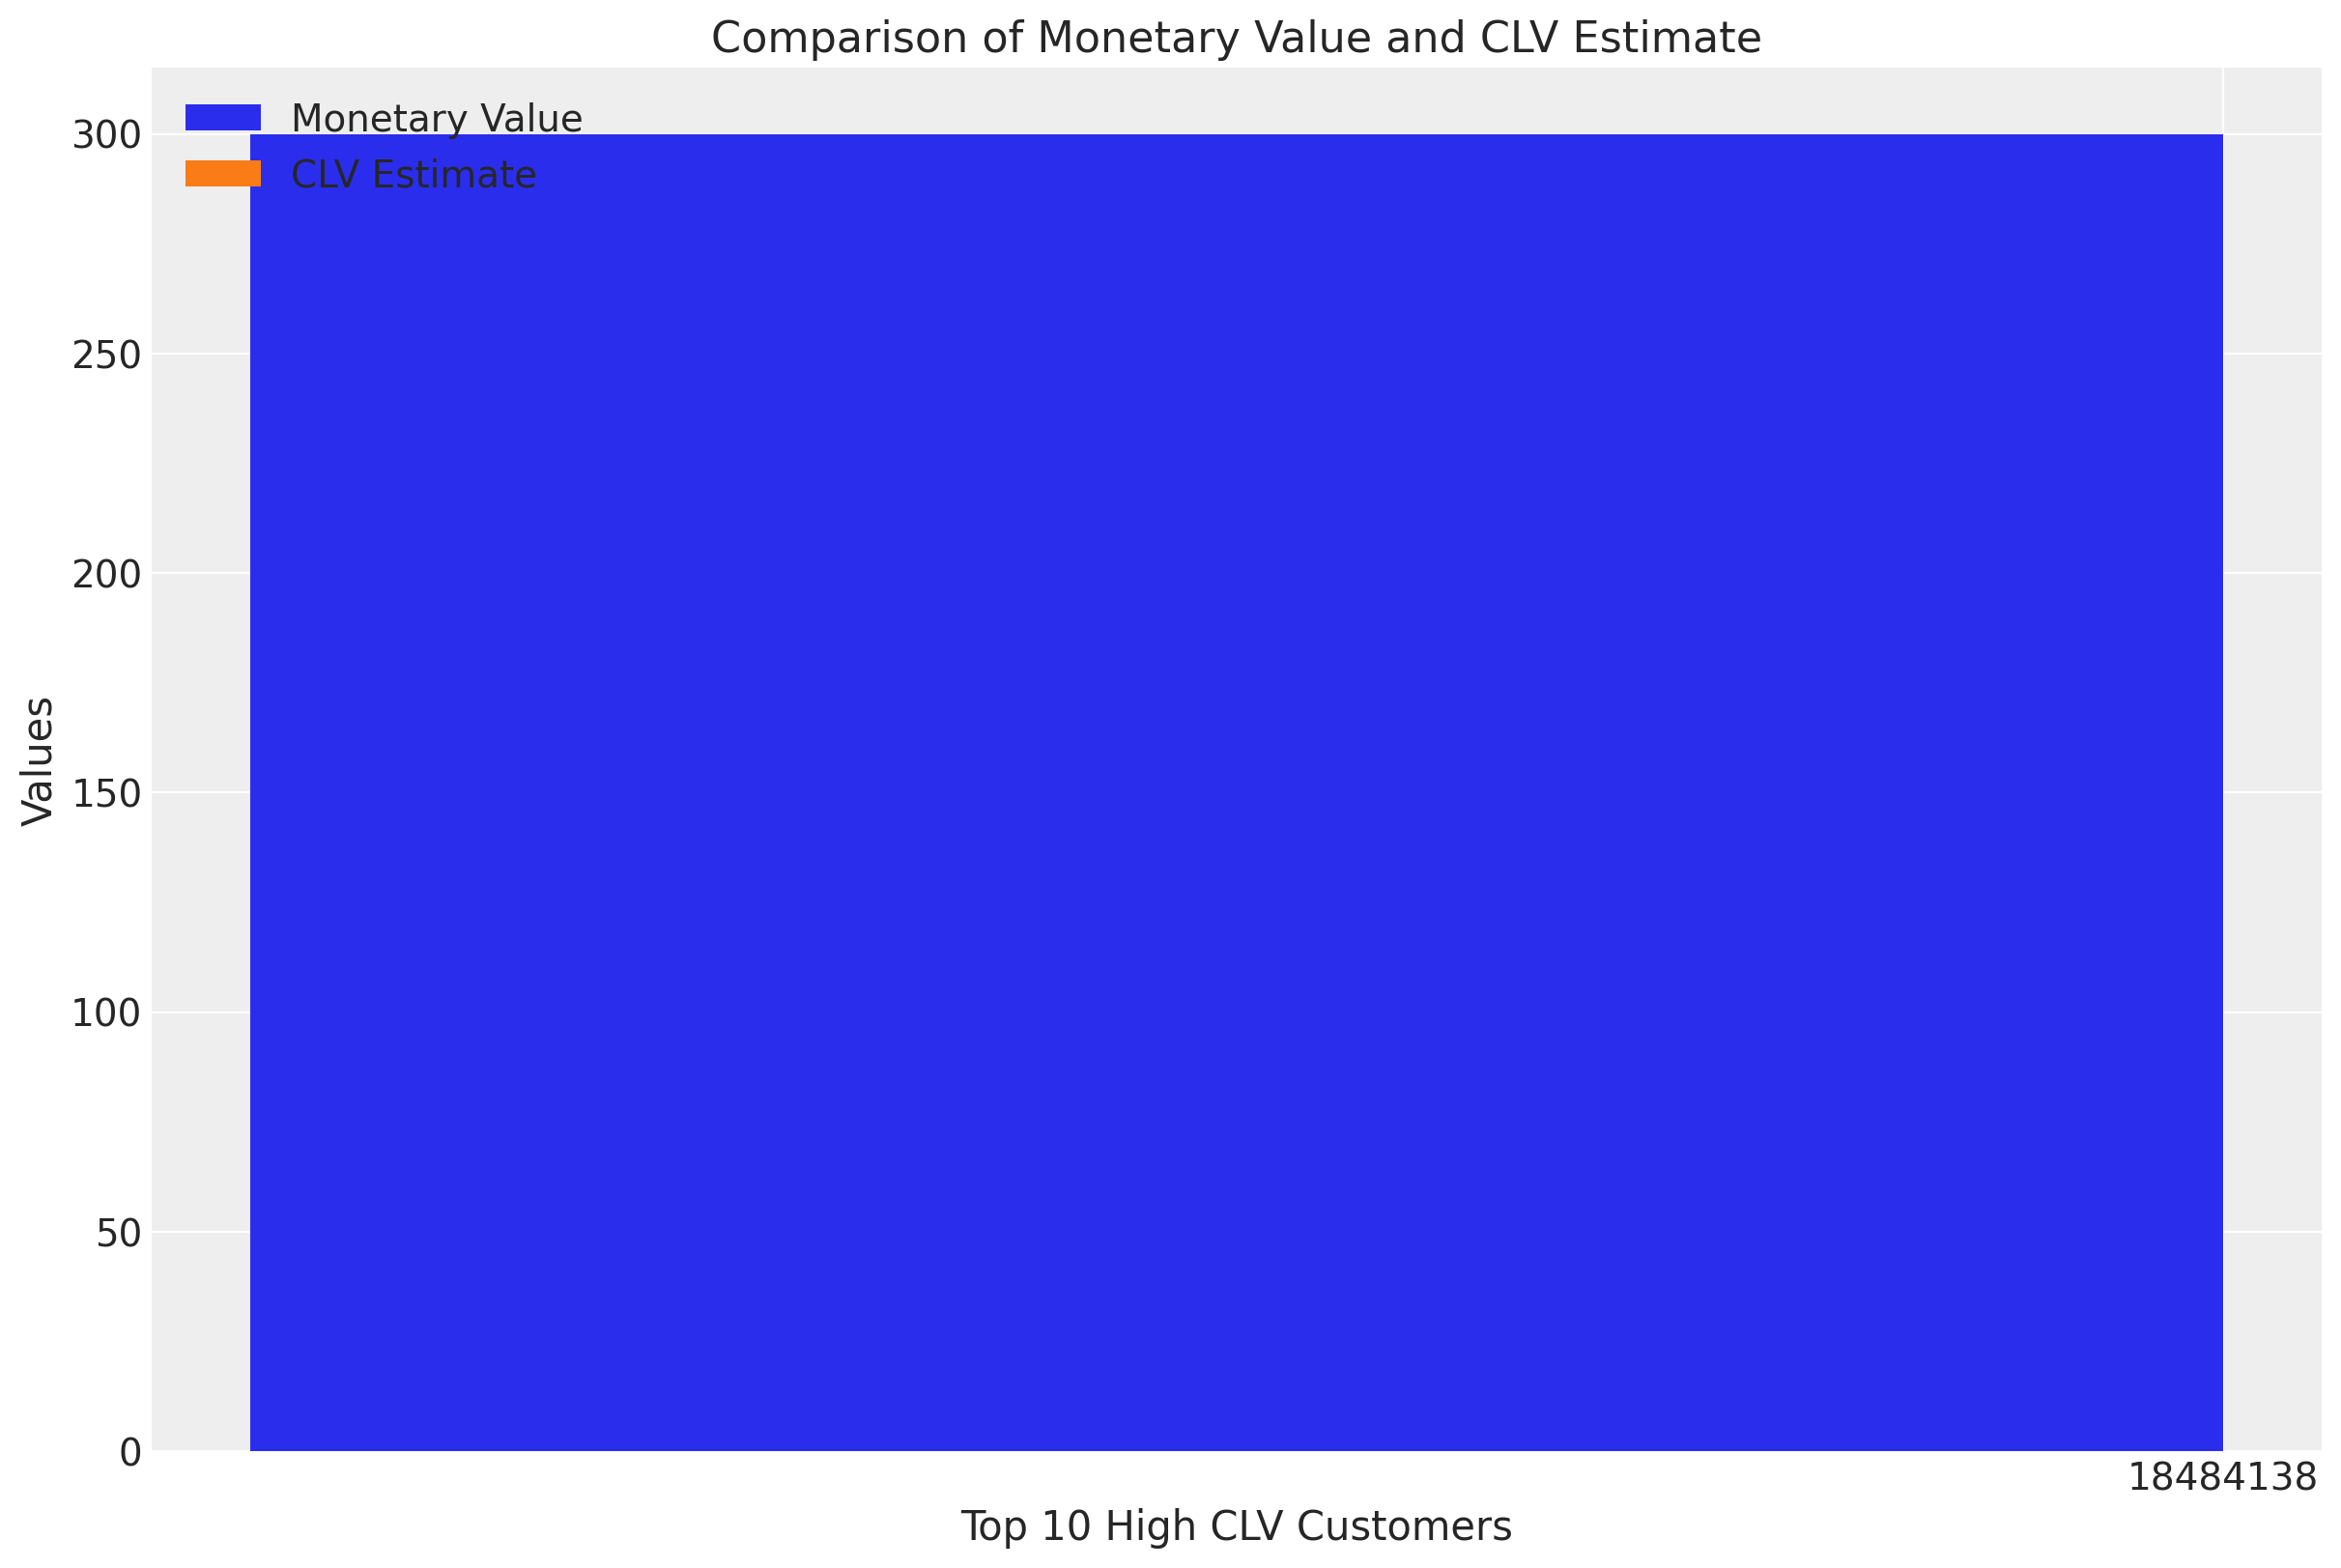

In [74]:
# These are customers whose future value significantly exceeds their past spending, representing prime opportunities for engagement.
top_10_clv = clv_df.sort_values(by='clv_estimate', ascending=False).head(10)

# Preparing a visual representation of this analysis.
fig, ax = plt.subplots(figsize=(12, 8))

# Setting up the positions for the bar components.
bar_width = 0.35
index = np.arange(len(top_10_clv))

# Bars representing the historical 'Monetary Value' for each customer. This is what each customer has previously contributed in terms of revenue.
bar1 = ax.bar(index, top_10_clv['monetary_value'], bar_width, label='Monetary Value')

# Bars showing the 'CLV Estimate' for each customer. This represents the future potential revenue from each customer, based on their projected lifetime value.
bar2 = ax.bar(index + bar_width, top_10_clv['clv_estimate'], bar_width, label='CLV Estimate')

# Enhancing the chart with labels, a title, and a legend for clarity.
ax.set_xlabel('Top 10 High CLV Customers')  # The x-axis shows the customers, sorted by the identified 'gap'.
ax.set_ylabel('Values')  # The y-axis represents the monetary amounts, both historical and projected.
ax.set_title('Comparison of Monetary Value and CLV Estimate')  # Chart title summarizing its purpose.
ax.set_xticks(index + bar_width / 2)  # Positioning the customer labels in the center of the grouped bars.
ax.set_xticklabels(top_10_clv['customer_id'])  # Customer IDs serve as the labels for the x-axis.
ax.legend()  # Including a legend makes the chart easier to interpret.

# Ensuring a clean layout before presenting the visualization. This step helps avoid any overlapping elements or clutter.
plt.tight_layout()

# Displaying the chart. This visualization serves as a strategic tool, highlighting where efforts could be concentrated for maximizing revenue.
plt.show()

In [75]:
# Calculating total sales per transaction
data['TotalSales'] = data['Quantity'] * data['UnitPrice']
customer_sales = data.groupby('CustomerID').agg({
    'TotalSales': sum,
    'Country': 'first'  # Assuming a customer is associated with only one country
})


customer_countries = customer_sales.reset_index()[['CustomerID', 'Country']]

clv_with_country = pd.merge(clv_df, customer_countries, left_on='customer_id', right_on='CustomerID', how='left')

average_clv_by_country = clv_with_country.groupby('Country')['clv_estimate'].mean()

customer_count_by_country = data.groupby('Country')['CustomerID'].nunique()

country_clv_summary = pd.DataFrame({
    'AverageCLV': average_clv_by_country,
    'CustomerCount': customer_count_by_country,
})

/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:1103: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:1104: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])


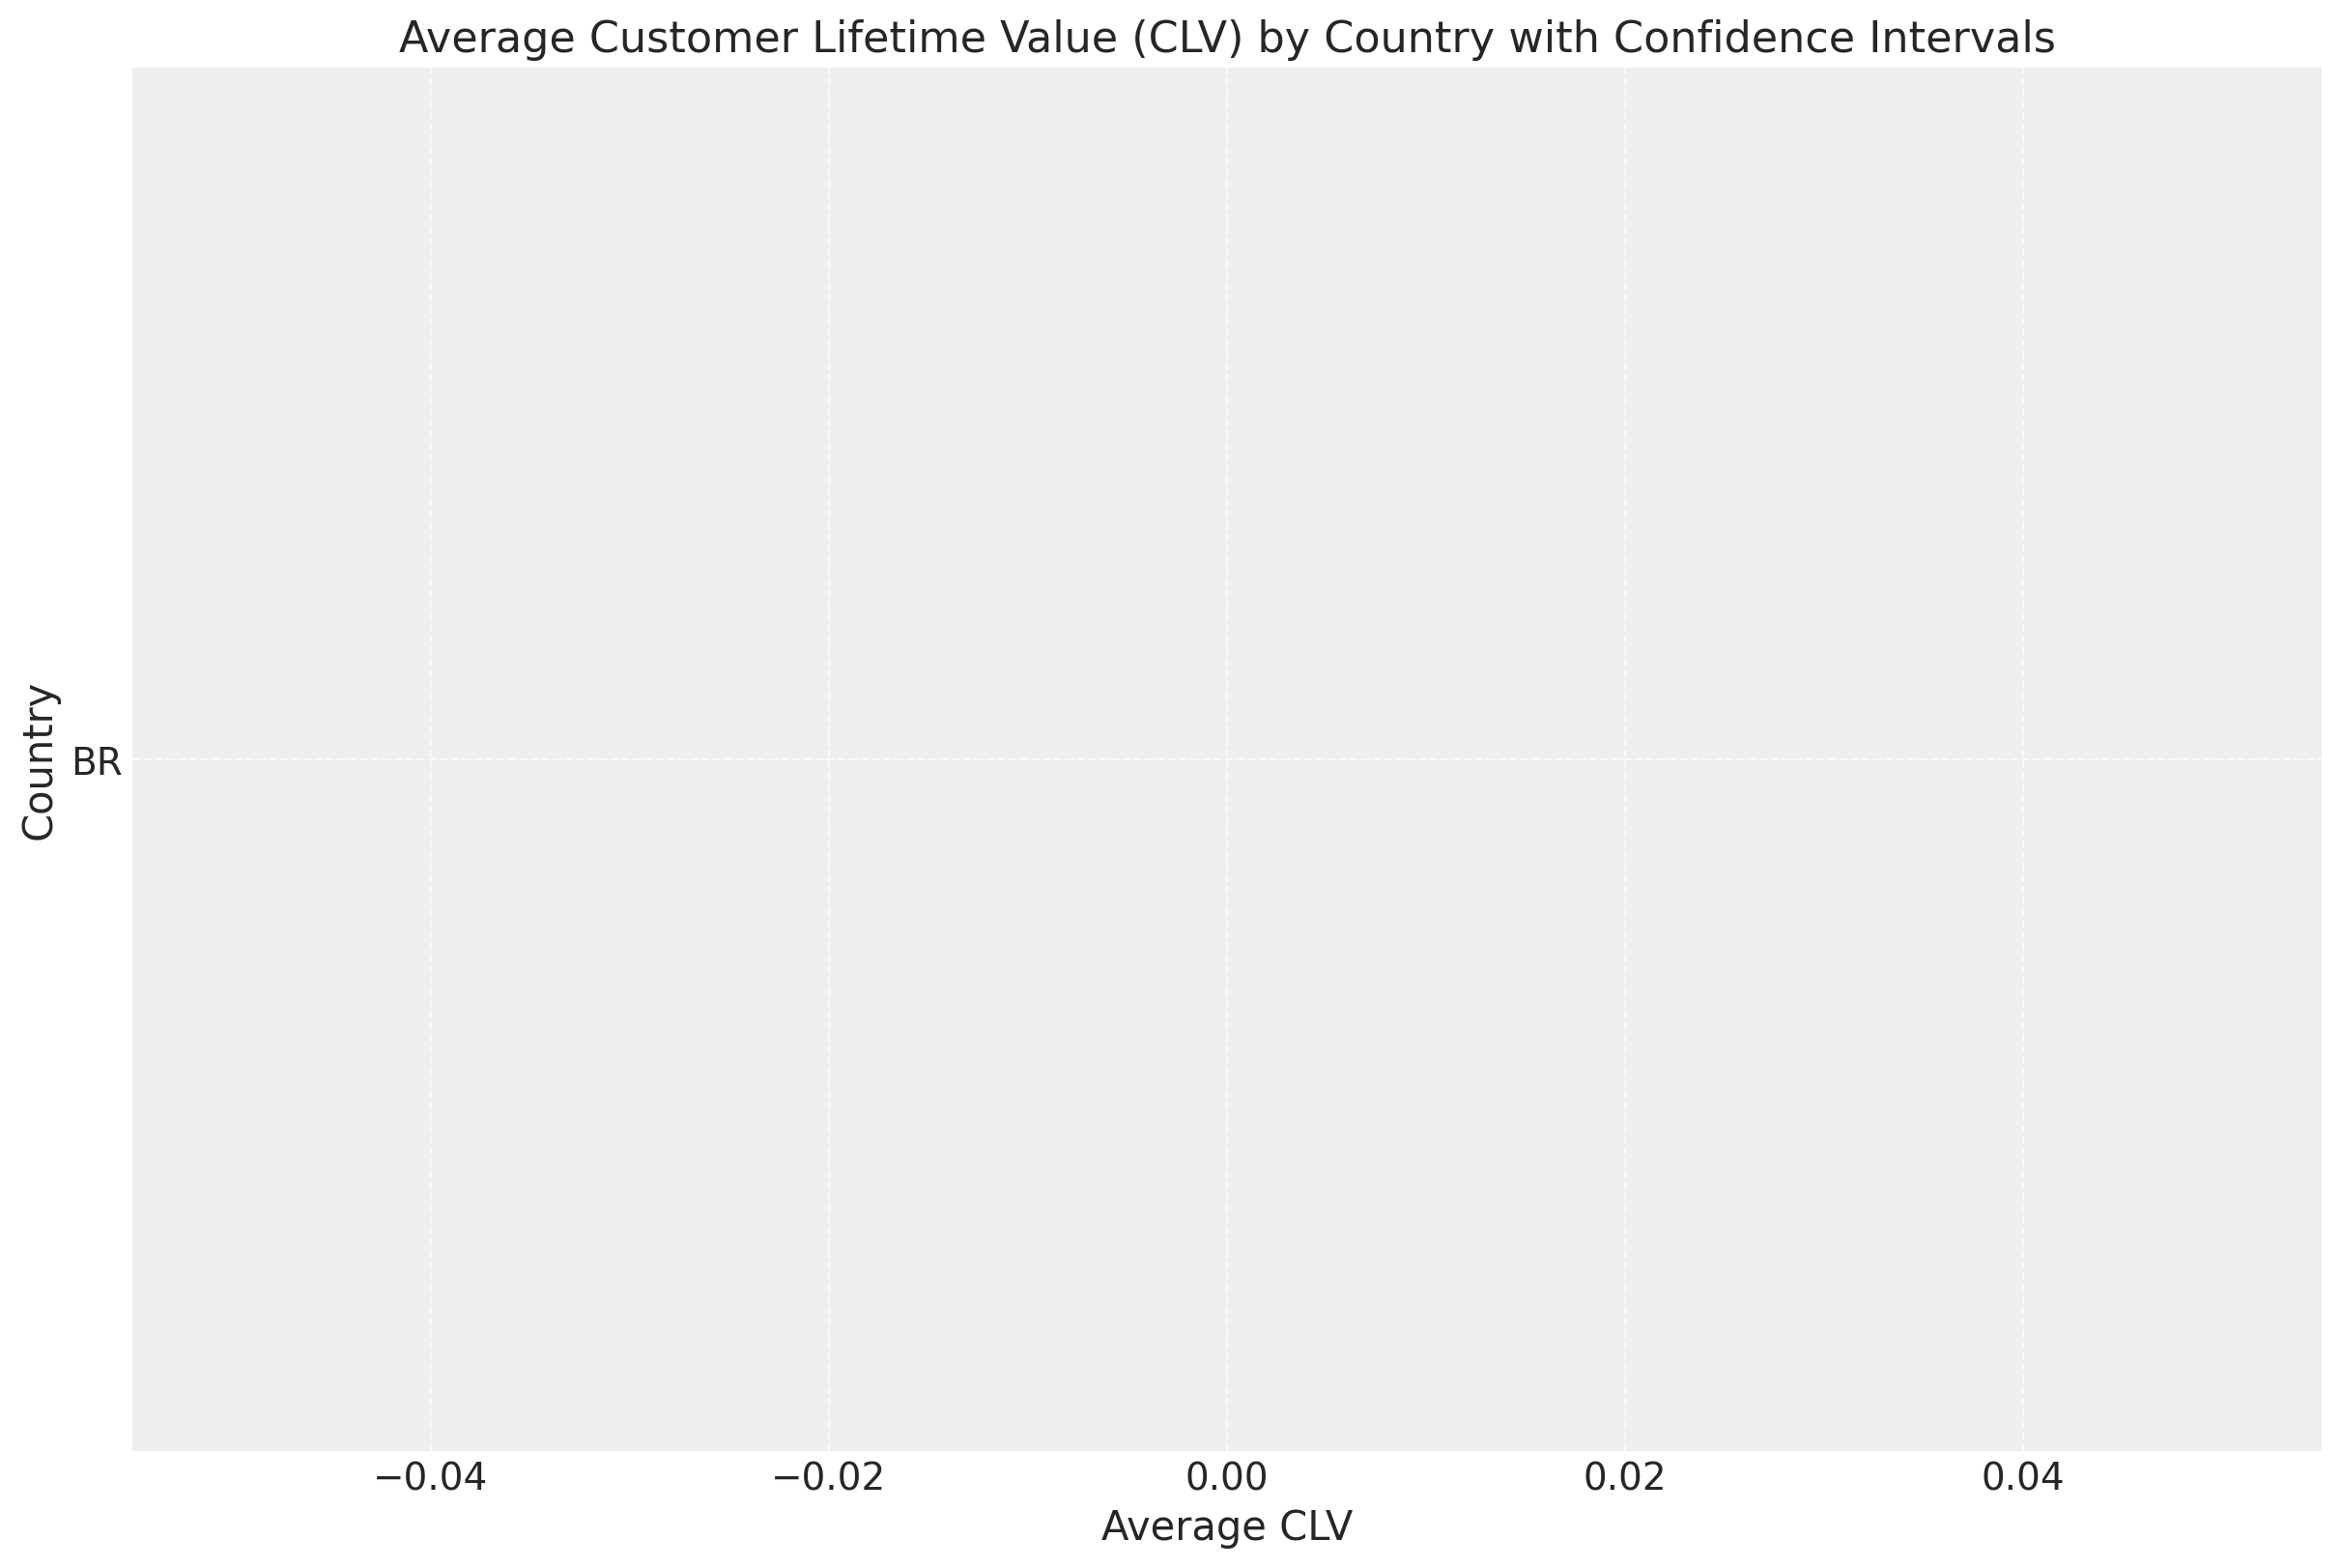

In [76]:
# Calculate the average lower and upper bounds of the CLV estimates by country
average_clv_lower_by_country = clv_with_country.groupby('Country')['clv_estimate_hdi_3%'].mean()
average_clv_upper_by_country = clv_with_country.groupby('Country')['clv_estimate_hdi_97%'].mean()

# Add these averages to the country_clv_summary dataframe
country_clv_summary['AverageCLVLower'] = average_clv_lower_by_country
country_clv_summary['AverageCLVUpper'] = average_clv_upper_by_country

# Filtering countries with more than 20 customers
filtered_countries = country_clv_summary[country_clv_summary['CustomerCount'] >= 20]

# Sorting in descending order by CustomerCount
sorted_countries = filtered_countries.sort_values(by='AverageCLV', ascending=False)

# Prepare the data for error bars
lower_error = sorted_countries['AverageCLV'] - sorted_countries['AverageCLVLower']
upper_error = sorted_countries['AverageCLVUpper'] - sorted_countries['AverageCLV']
asymmetric_error = [lower_error, upper_error]

# Create a new figure with a specified size
plt.figure(figsize=(12,8))

# Create a plot representing the average CLV with error bars indicating the confidence intervals
# We convert the index to a regular list to avoid issues with matplotlib's handling of pandas Index objects
plt.errorbar(x=sorted_countries['AverageCLV'], y=sorted_countries.index.tolist(),
             xerr=asymmetric_error, fmt='o', color='black', ecolor='lightgray', capsize=5, markeredgewidth=2)

# Set labels and title
plt.xlabel('Average CLV')  # x-axis label
plt.ylabel('Country')  # y-axis label
plt.title('Average Customer Lifetime Value (CLV) by Country with Confidence Intervals')  # chart title

# Adjust the y-axis to display countries from top down
plt.gca().invert_yaxis()

# Show the grid lines
plt.grid(True, linestyle='--', alpha=0.7)

# Display the plot
plt.show()

THE END